# Time Series Analysis Notebook

**By:** Mohamed Ezzat

---

## Objective

We have 96 time series datasets. For each dataset, our goal is to create a model that achieves the **best RMSE** and provides **accurate predictions**. The following pipeline outlines the steps we'll take to achieve this:

---

## Pipeline

1. **Exploratory Data Analysis (EDA)** for the dataset.
2. Detecting the **best algorithm for filling missing values** (handling nulls).
3. Analyzing the data components:
   - **Trend**
   - **Seasonality**
   - **Autocorrelation**
4. **Feature extraction** to enhance model performance.
5. **Model training and Evaluation** on the dataset.
6. **Saving the best model** and developing an **API for usage**.

---

This notebook will guide you through the step-by-step process of working with time series data, from exploratory analysis to model development, and ultimately, to deployment through an API.


In [2]:
import sys
print(sys.version)


3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


### Exploratory Data Analysis

In [4]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('train_splits/train_9.csv')

# Display Rows
df.head()



value            timestamp  anomaly
0 -0.925347  2021-07-01 00:00:00    False
1 -1.053632  2021-07-01 00:10:00    False
2 -1.023581  2021-07-01 00:20:00    False
3 -0.959519  2021-07-01 00:30:00    False
4 -1.154035  2021-07-01 00:40:00    False

In [5]:
# Check for missing values
df.isnull().sum()

value        1231
timestamp       0
anomaly         0
dtype: int64

### Handling Nulls (Linear Interpolation vs Iterative Imputation)

In [7]:
# Summary of the dataset
df.describe()

value
count  22961.000000
mean      -0.845377
std        0.303192
min       -1.439961
25%       -1.020311
50%       -0.927183
75%       -0.771639
max        0.998917

In [8]:
# Applying linear interpolation
df_interpolated = df.copy()
df_interpolated['value'] = df_interpolated['value'].interpolate(method='linear')

df_interpolated.describe()

value
count  24192.000000
mean      -0.845695
std        0.300191
min       -1.439961
25%       -1.019587
50%       -0.927655
75%       -0.770816
max        0.998917

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



df_iterative = df.copy()
iter_imputer = IterativeImputer(max_iter=10, random_state=42)
df_iterative['value'] = iter_imputer.fit_transform(df_iterative[['value']])


df_iterative.describe()


value
count  24192.000000
mean      -0.845377
std        0.295377
min       -1.439961
25%       -1.015093
50%       -0.915753
75%       -0.786151
max        0.998917

As observed, **Linear Interpolation** preserves most of the characteristics of the original data with only a slight difference in the mean. Most other statistical properties remain consistent, making it a **reliable method** for handling missing data.


## Analyzing the Data Components

### Difference Between ACF and PACF Plots:

- **Autocorrelation Function (ACF) Plot**:
  - The ACF plot shows the correlation between the time series and its **lagged values**. It tells us how each value in the time series is related to past values at different time lags. A high value indicates that the series has some correlation with its previous values at that lag.
  
- **Partial Autocorrelation Function (PACF) Plot**:
  - The PACF plot shows the correlation between the time series and its lagged values **after removing the effects of shorter lags**. It isolates the direct relationship between a time series and its lag at a specific time step, giving a clearer picture of how much a particular lag influences the series.


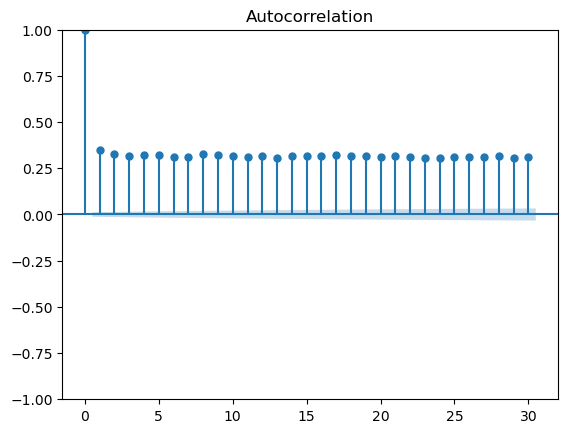

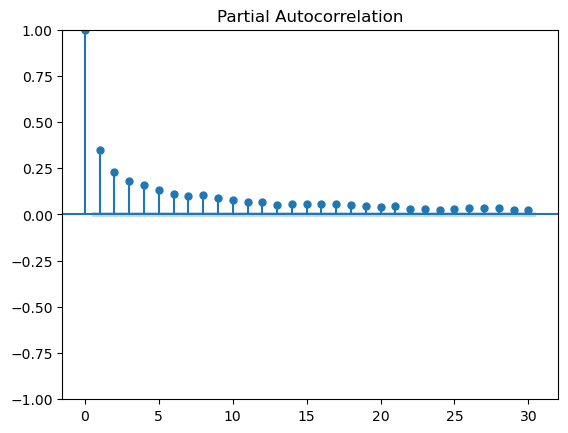

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF plot
plot_acf(df_interpolated['value'], lags=30)
plt.show()

# PACF plot
plot_pacf(df_interpolated['value'], lags=30)
plt.show()


As obeserved in the two graph the lag values of 3 or 4 is suffcient for the data as features

## Now let us check the data structure  (stationary vs non-stationary)

In [15]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd


result = adfuller(df_interpolated['value'])
print('p-value:', result[1])

 
   
cnt= 0
while(result[1] > 0.05):
        print(f'The time series is not stationary. Applying differencing{cnt}')
        df['value'] = df_interpolated['value'].diff()
        df['value'] = df_interpolated['value'].bfill()
        result = adfuller(df_interpolated['value'])
        print('New p-value after differencing:', result[1])
    
       
print('The differenced time series is stationary.')
        

p-value: 1.654229760652117e-06
The differenced time series is stationary.


## Data Decomposition

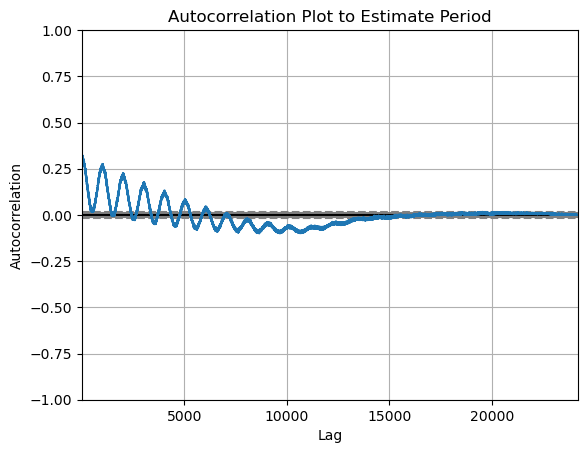

In [17]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Plot the autocorrelation to detect periodic patterns
autocorrelation_plot(df_interpolated['value'])
plt.title('Autocorrelation Plot to Estimate Period')
plt.show()


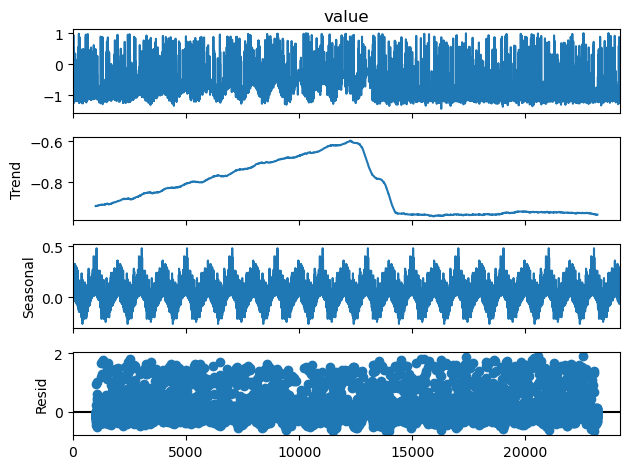

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform classical decomposition (additive model as observed in data visualization)
decomposition = seasonal_decompose(df_interpolated['value'], model='additive',period=2000)

# Plot the decomposed components
decomposition.plot()
plt.show()


### Building the Pipeline

We will now build a pipeline to test the data on different models, including:
- **XGBoost** (an Ensemble machine learning model),
- **Linear Regression** (a classical machine learning model),
- **ARIMA**
- **Prophet**.


### Feature Selection Process

After trying many combinations of features and measuring feature importance, which will be shown in the upcoming graph, the final selected features are:

- **Minute of Hour**: Helps capture the time-related patterns within each hour.
- **3 Lag Features**: Proven to be significant by analyzing the AutoCorrelation Function (ACF).
- **Rolling Mean**: Provides a smooth trend by averaging data over a specified window.
- **Rolling Standard Deviation (std)**: Captures the variability of the data over a rolling window.
- **Fast Fourier Transform (FFT)**: Helps capture the frequency domain characteristics of the time series data.



In [21]:

# Feature Engineering Function
def create_features(df, max_lag=3):
    """
    Create time, lag, rolling stats, Fourier features.
    """

    # Extract time features
    df['minute_of_hour'] = df.index.minute
    #df['day_of_week'] = df.index.dayofweek
    #df['month_of_year'] = df.index.month
    #df['week_of_month'] = ((df.index.day - 1) // 7) + 1
    #df['day_of_month'] = df.index.day


    # Extract lag features 3
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['value'].shift(lag)

    # Extract rolling stat features
    df['rolling_mean'] = df['value'].rolling(window=3).mean()
    df['rolling_std'] = df['value'].rolling(window=3).std()

    df.fillna(method='bfill', inplace=True)

    # Extract Fourier Features
    fft_components = np.fft.fft(df['value'])
    fft_df = pd.DataFrame({
        'fft_real': np.real(fft_components),
    }, index=df.index)
    df['fft_real'] = fft_df['fft_real']

    
    return df


In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def preprocess_data(df):
    if 'anomaly' in df.columns:
        df.drop('anomaly', axis=1, inplace=True)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('timestamp', inplace=True)
    
    result = adfuller(df['value'])
    cnt = 0
    while result[1] > 0.05:
        print(f'The time series is not stationary. Applying differencing {cnt}')
        df['value'] = df['value'].diff().bfill()
        result = adfuller(df['value'])
        print('New p-value after differencing:', result[1])
        cnt += 1
    
    print('The differenced time series is stationary.')
    
    df = create_features(df)
    
    return df


In [23]:
import joblib


# ARIMA Model
def train_arima_model(train_df):
    arima_order = (1, 0, 2)
    arima_model = ARIMA(train_df['value'], order=arima_order).fit()
    return arima_model

# Prophet Model
def train_prophet_model(train_df):
    prophet_train_df = train_df.reset_index()[['timestamp', 'value']].rename(
        columns={'timestamp': 'ds', 'value': 'y'}
    )
    prophet_model = Prophet()
    prophet_model.fit(prophet_train_df)
    return prophet_model

# XGBoost Model
def train_xgboost_model(train_df):
    feature_cols = [col for col in train_df.columns if col != 'value']
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    xgb_model.fit(train_df[feature_cols], train_df['value'])

    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    plot_importance(xgb_model, importance_type='weight', xlabel='F Score', height=0.8)
    plt.title('XGBoost Feature Importance')
    plt.show()

    return xgb_model

# Linear Regression Model
def train_linear_regression_model(train_df):
    feature_cols = [col for col in train_df.columns if col != 'value']
    lin_reg_model = LinearRegression()
    lin_reg_model.fit(train_df[feature_cols], train_df['value'])

    return lin_reg_model

# Save model to directory
def save_model(model, dataset_name):
    
    models_dir = 'models'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
        
    model_filename = os.path.join(models_dir, dataset_name.replace('train', 'model').replace('.csv', '.pkl')) 
                                  
    joblib.dump(model, model_filename)
    print(f"Best model saved as: {model_filename}")


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import joblib


def Model_Evaluation(model, train_df, val_df, test_df, model_name):
    """
    Calculate RMSE on training, validation, and test sets and plot residuals for the testing data only.
    """
    # Prediction for training, validation, and test data
    if model_name == 'ARIMA':
        train_pred = model.predict(start=train_df.index[0], end=train_df.index[-1])
        
        val_pred = model.forecast(steps=len(val_df))
        
        test_pred = model.forecast(steps=len(test_df))

    elif model_name == 'Prophet':
        prophet_train_df = train_df.reset_index()[['timestamp', 'value']].rename(
            columns={'timestamp': 'ds', 'value': 'y'}
        )
        future_train = model.make_future_dataframe(periods=0)
        future_val = model.make_future_dataframe(periods=len(val_df), freq='D')
        future_test = model.make_future_dataframe(periods=len(test_df), freq='D')
        train_pred = model.predict(future_train)['yhat'].values
        val_pred = model.predict(future_val)['yhat'][-len(val_df):].values
        test_pred = model.predict(future_test)['yhat'][-len(test_df):].values

    elif model_name == 'XGBoost':
        feature_cols = [col for col in train_df.columns if col != 'value']
        train_pred = model.predict(train_df[feature_cols])
        val_pred = model.predict(val_df[feature_cols])
        test_pred = model.predict(test_df[feature_cols])

    elif model_name == 'LinearRegression':
        feature_cols = [col for col in train_df.columns if col != 'value']
        train_pred = model.predict(train_df[feature_cols])
        val_pred = model.predict(val_df[feature_cols])
        test_pred = model.predict(test_df[feature_cols])
        
   
    val_residuals = (val_df['value']) - (val_pred)
   
    # Plot residuals for testing data
    plt.figure(figsize=(10, 6))
    plt.plot(val_df.index, val_residuals, label='val Residuals')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
    plt.title(f"{model_name} Residuals on Validation Data")
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

    # Calculate RMSE for training, validation, and test data
    train_rmse = np.sqrt(mean_squared_error(train_df['value'], train_pred))
    val_rmse = np.sqrt(mean_squared_error(val_df['value'], val_pred))
    test_rmse = np.sqrt(mean_squared_error(test_df['value'], test_pred))
    
    # Print RMSE for each dataset
    print(f"RMSE on training data for {model_name}: {train_rmse}")
    print(f"RMSE on validation data for {model_name}: {val_rmse}")
    print(f"RMSE on test data for {model_name}: {test_rmse}")

    return train_rmse, val_rmse, test_rmse 


In [25]:
from sklearn.model_selection import train_test_split


if __name__ == "__main__":
    # Load train data
    dataset_name = 'train_9.csv'
    df = pd.read_csv('train_splits/train_9.csv')
    # Load test data
    test_df = pd.read_csv('test_splits/test_9.csv')

    split_idx = int(0.8 * len(df))
    train_df = df[:split_idx] 
    val_df = df[split_idx:]
    
    # Preprocess Data
    train_df = preprocess_data(train_df)
    val_df =  preprocess_data(val_df)
    test_df = preprocess_data(test_df)



    best_rmse = float('inf')
    best_model = None
    best_model_name = ""


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

The differenced time series is stationary.
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


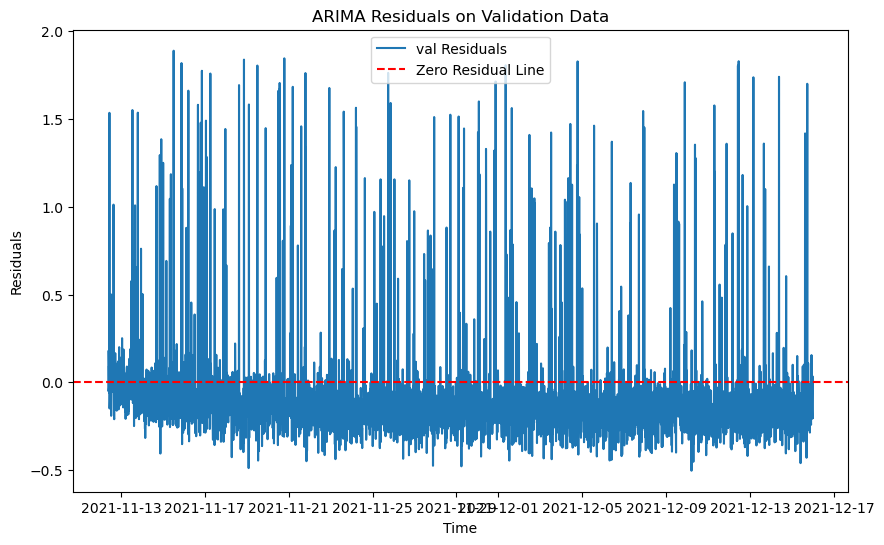

RMSE on training data for ARIMA: 0.24583794394705497
RMSE on validation data for ARIMA: 0.28869840670186225
RMSE on test data for ARIMA: 0.8746244256854737


In [26]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import joblib  # for saving models
import warnings

arima_model = train_arima_model(train_df)
train_rmse, val_rmse, test_rmse = Model_Evaluation(arima_model, train_df, val_df, test_df, 'ARIMA')
if val_rmse < best_rmse:
    best_rmse = val_rmse
    best_model = arima_model
    best_model_name = 'ARIMA'


21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:48 - cmdstanpy - INFO - Chain [1] done processing


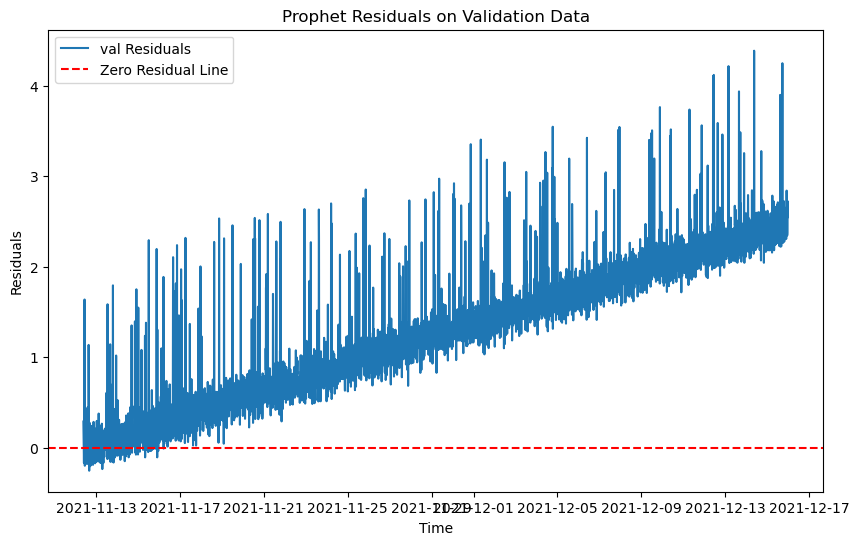

RMSE on training data for Prophet: 0.25885298184972105
RMSE on validation data for Prophet: 1.4902916286777368
RMSE on test data for Prophet: 3.8976348473949116


In [27]:

prophet_model = train_prophet_model(train_df)
train_rmse, val_rmse, test_rmse = Model_Evaluation(prophet_model, train_df, val_df, test_df, 'Prophet')


if val_rmse < best_rmse:
    best_rmse = val_rmse
    best_model = prophet_model
    best_model_name = 'Prophet'


<Figure size 1000x800 with 0 Axes>

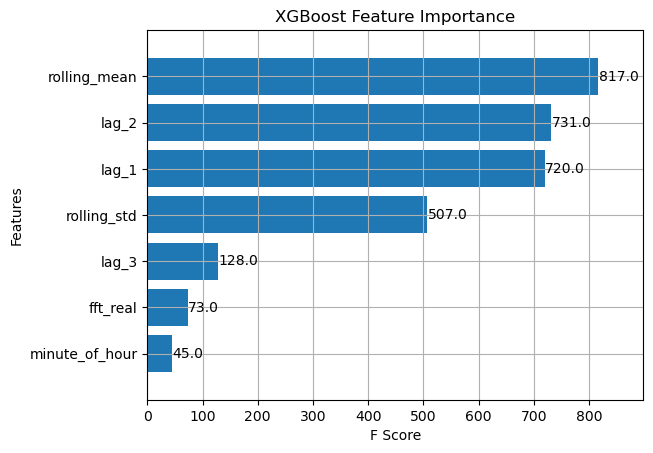

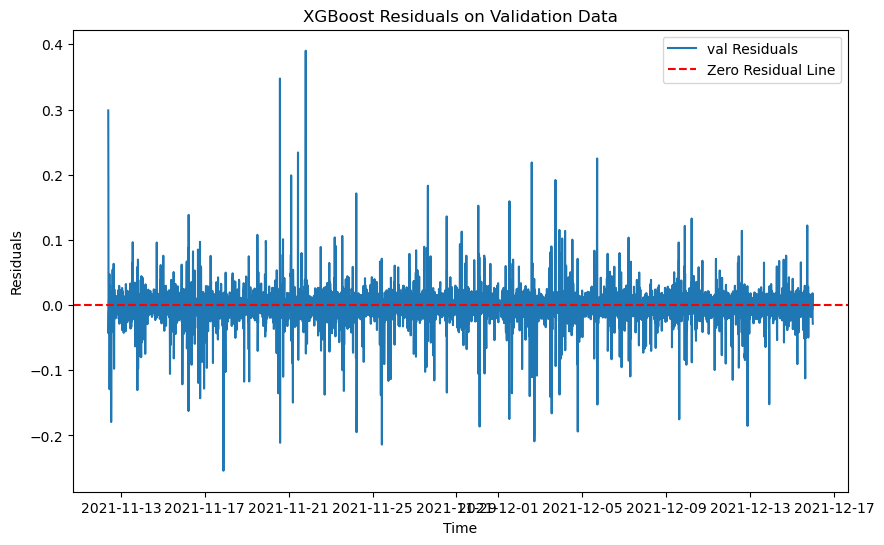

RMSE on training data for XGBoost: 0.027269334515571973
RMSE on validation data for XGBoost: 0.030226056626547898
RMSE on test data for XGBoost: 0.6364074978120855


In [28]:
#XGBoost model
xgb_model = train_xgboost_model(train_df)
train_rmse, val_rmse, test_rmse = Model_Evaluation(xgb_model, train_df, val_df, test_df, 'XGBoost')
if val_rmse < best_rmse:
    best_rmse = val_rmse
    best_model = xgb_model
    best_model_name = 'XGBoost'

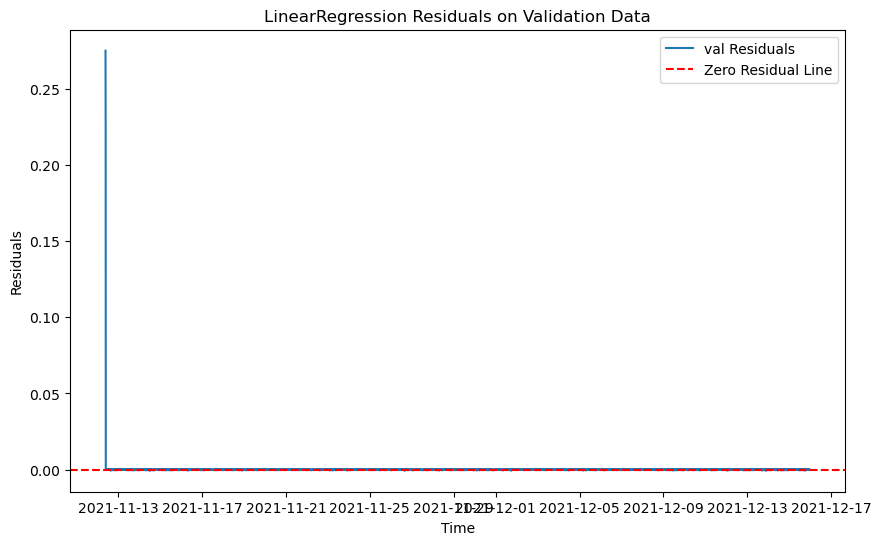

RMSE on training data for LinearRegression: 0.0006798950884596284
RMSE on validation data for LinearRegression: 0.005116497089577499
RMSE on test data for LinearRegression: 0.0017213242622314009


In [29]:
# Linear Regression
lin_reg_model = train_linear_regression_model(train_df)
train_rmse, val_rmse, test_rmse = Model_Evaluation(lin_reg_model, train_df, val_df, test_df, 'LinearRegression')

if val_rmse < best_rmse:
    best_rmse = val_rmse
    best_model = lin_reg_model
    best_model_name = 'LinearRegression'



In [30]:
# Print the best model and save it
print(f"\nBest model is {best_model_name} with RMSE: {best_rmse}")
save_model(best_model, dataset_name)



Best model is LinearRegression with RMSE: 0.005116497089577499
Best model saved as: models\model_9.pkl


### Model Evaluation Summary

After testing and evaluating various models, the best-performing model for this task was the **Linear Regression** model. Following closely behind was the **XGBoost** model.

This indicates that classical machine learning models, in some cases, outperform specialized time series models like **Prophet** and **ARIMA**.

- Now let us try this pipline on all datasets 


train_102.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 4.679196181757723e-25
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 6.717974829163156e-19
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')
C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

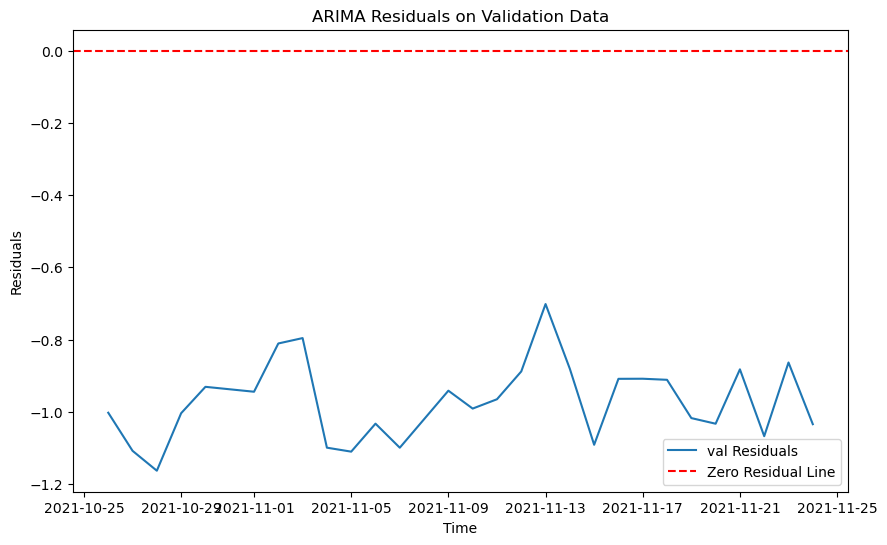

21:03:58 - cmdstanpy - INFO - Chain [1] start processing
21:03:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.5233218428042806
RMSE on validation data for ARIMA: 0.9771388760725562
RMSE on test data for ARIMA: 0.4376068736582135


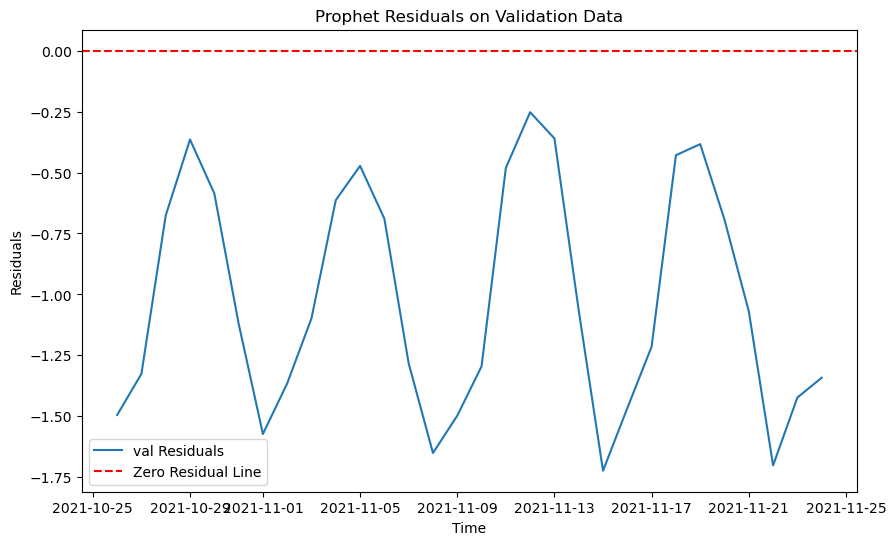

RMSE on training data for Prophet: 0.35499759961958116
RMSE on validation data for Prophet: 1.1242783346194918
RMSE on test data for Prophet: 0.682772612000259


<Figure size 1000x800 with 0 Axes>

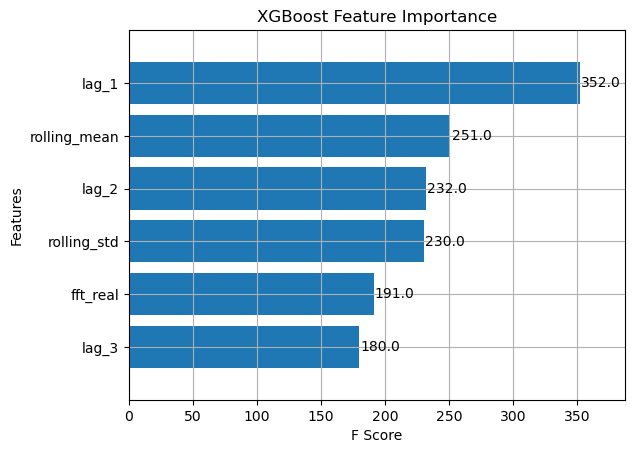

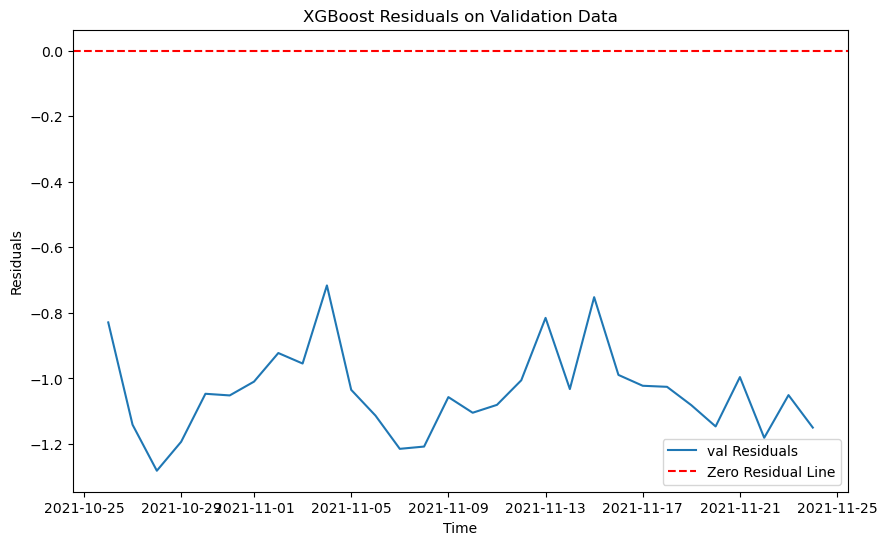

RMSE on training data for XGBoost: 0.010913452241430052
RMSE on validation data for XGBoost: 1.04861085325162
RMSE on test data for XGBoost: 0.18158012062944703


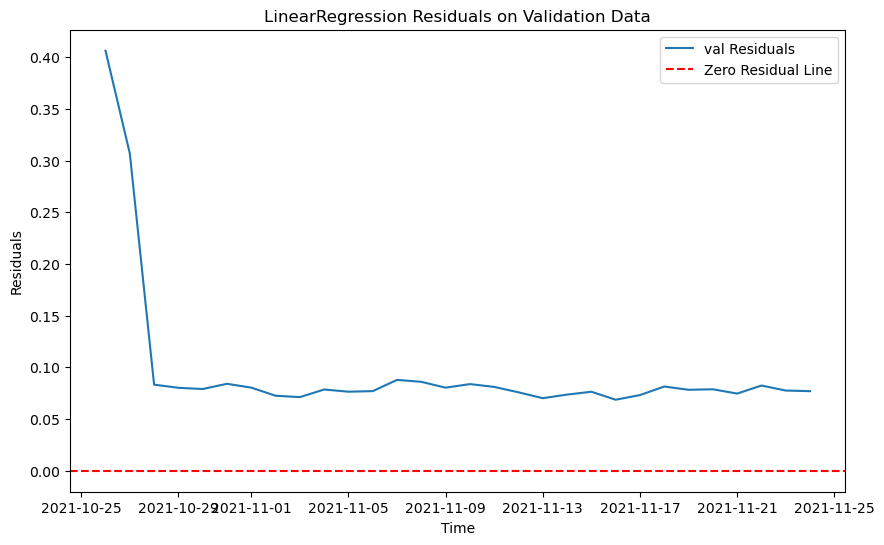

RMSE on training data for LinearRegression: 0.04640377396358287
RMSE on validation data for LinearRegression: 0.11985713864115388
RMSE on test data for LinearRegression: 0.013775041388424534

Best model is LinearRegression with RMSE: 0.11985713864115388
Best model saved as: models\model_102.pkl
data num 1
train_103.csv
The differenced time series is stationary.
The differenced time series is stationary.
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

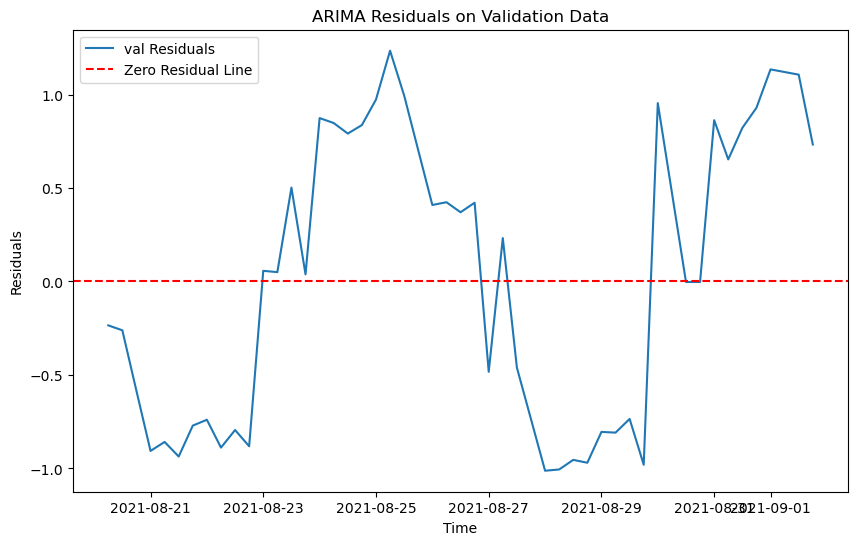

21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.39060113253662565
RMSE on validation data for ARIMA: 0.7644762039613969
RMSE on test data for ARIMA: 0.7273338899159498


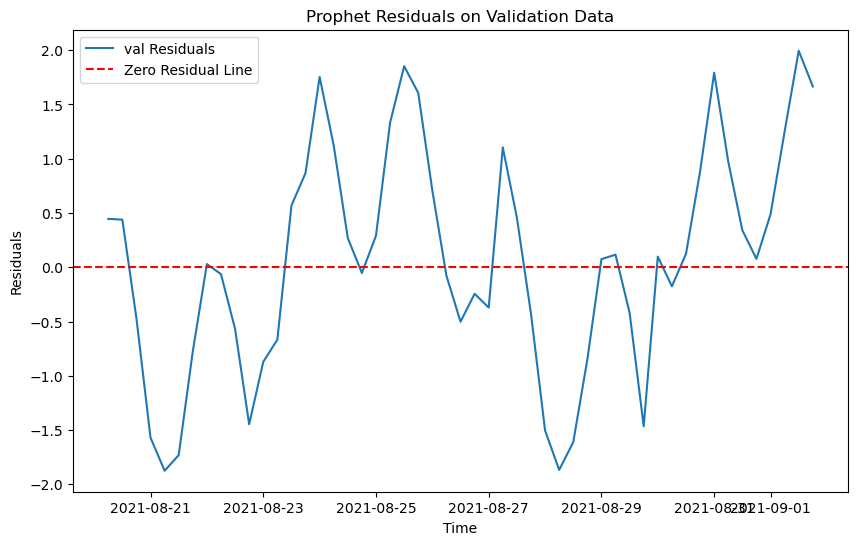

RMSE on training data for Prophet: 0.26343899744372323
RMSE on validation data for Prophet: 1.0368147681417126
RMSE on test data for Prophet: 1.0026165098930477


<Figure size 1000x800 with 0 Axes>

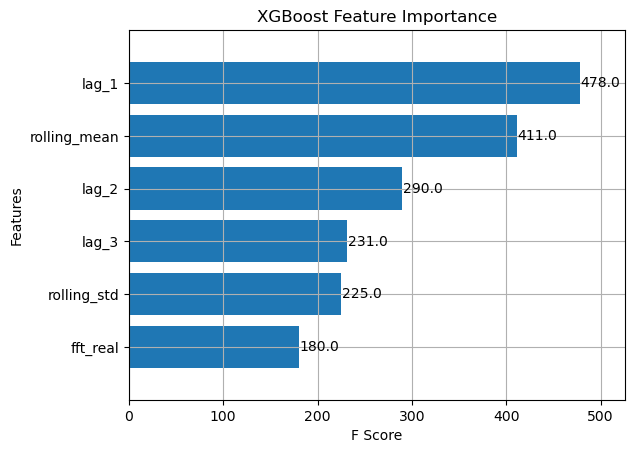

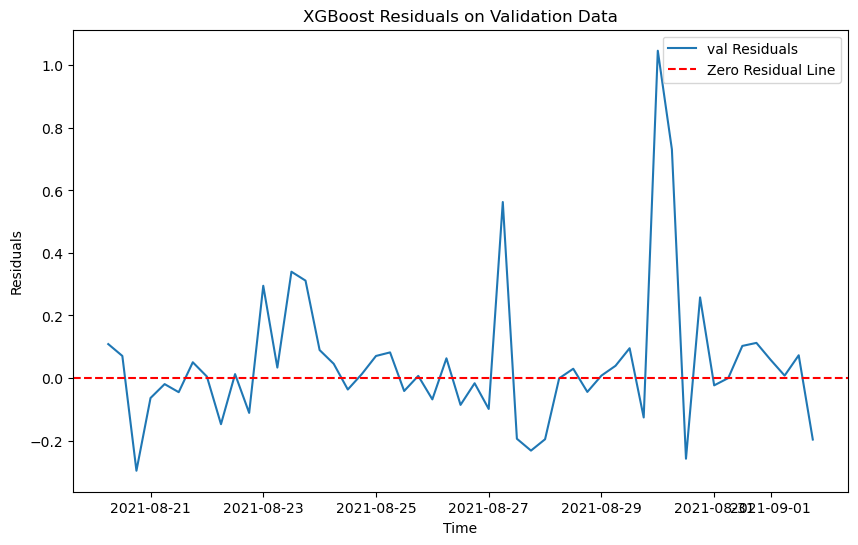

RMSE on training data for XGBoost: 0.013451719238414468
RMSE on validation data for XGBoost: 0.2348056433067759
RMSE on test data for XGBoost: 0.10078870654747674


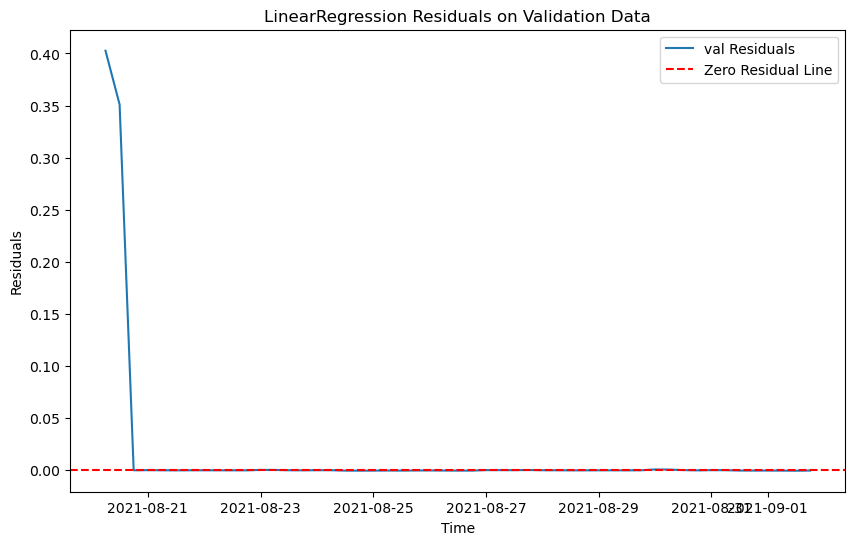

RMSE on training data for LinearRegression: 0.0016784840151993666
RMSE on validation data for LinearRegression: 0.07479170778628798
RMSE on test data for LinearRegression: 0.002628734017107163

Best model is LinearRegression with RMSE: 0.07479170778628798
Best model saved as: models\model_103.pkl
data num 2
train_105.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 7.331318151184474e-10
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.577231885263625e-14
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')
C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

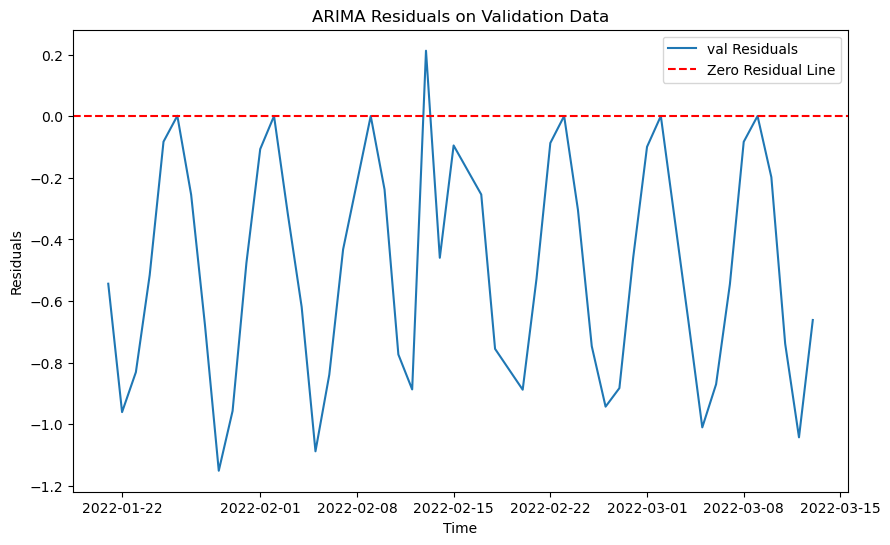

21:04:02 - cmdstanpy - INFO - Chain [1] start processing
21:04:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.3062226659535955
RMSE on validation data for ARIMA: 0.6077163327674805
RMSE on test data for ARIMA: 0.6268333530678069


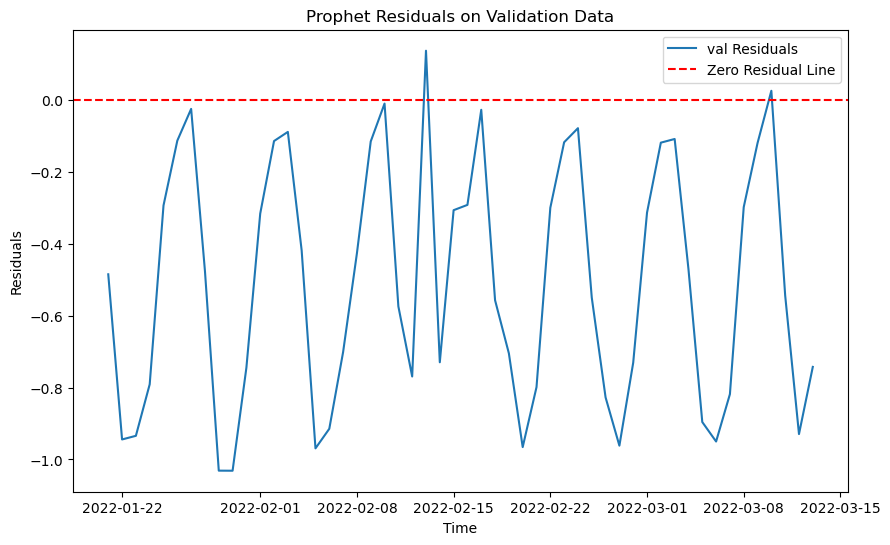

RMSE on training data for Prophet: 0.2978703719382203
RMSE on validation data for Prophet: 0.6126367896447981
RMSE on test data for Prophet: 0.7737332763149788


<Figure size 1000x800 with 0 Axes>

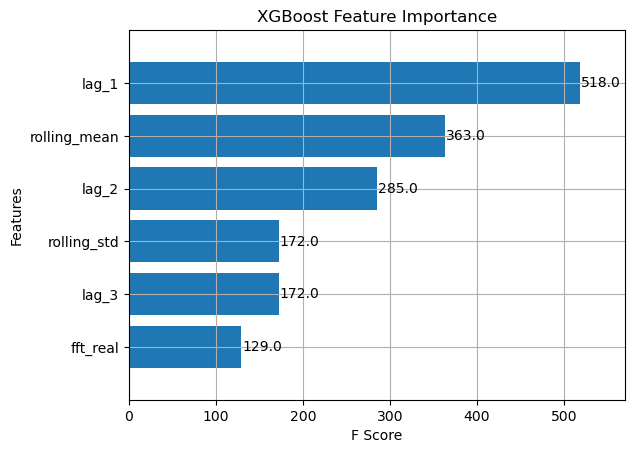

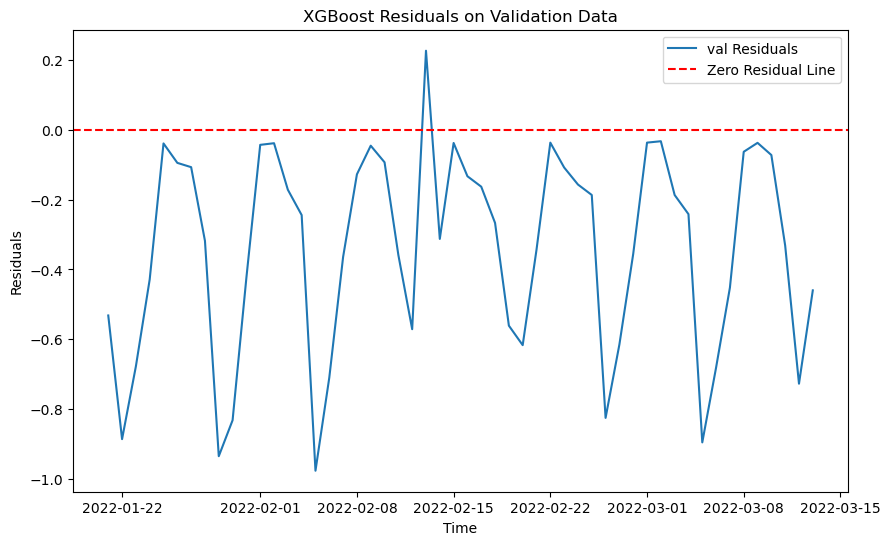

RMSE on training data for XGBoost: 0.009710759699452166
RMSE on validation data for XGBoost: 0.44960031609539286
RMSE on test data for XGBoost: 0.3955395748130487


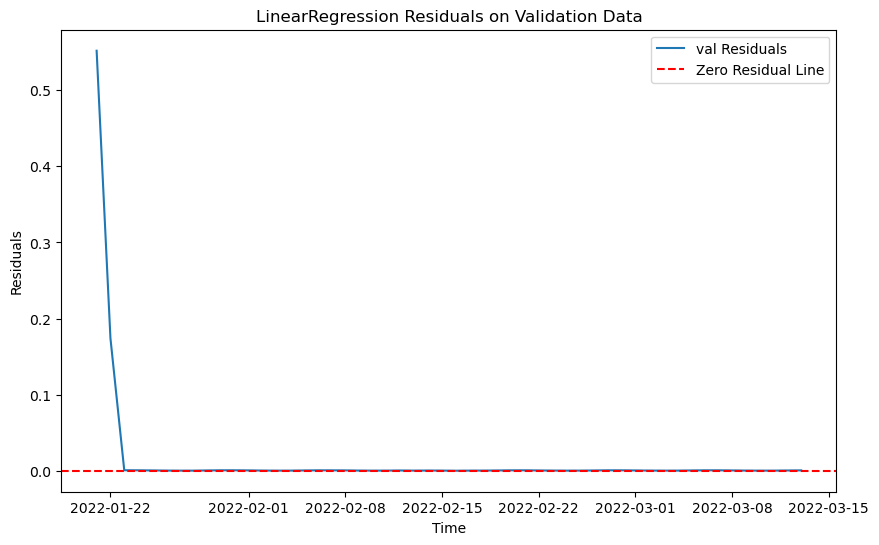

RMSE on training data for LinearRegression: 0.0005099397573412311
RMSE on validation data for LinearRegression: 0.08026021132894232
RMSE on test data for LinearRegression: 0.029636527895818703

Best model is LinearRegression with RMSE: 0.08026021132894232
Best model saved as: models\model_105.pkl
data num 3
train_110.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 3.872505470229485e-24
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 3.022931336577495e-19
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

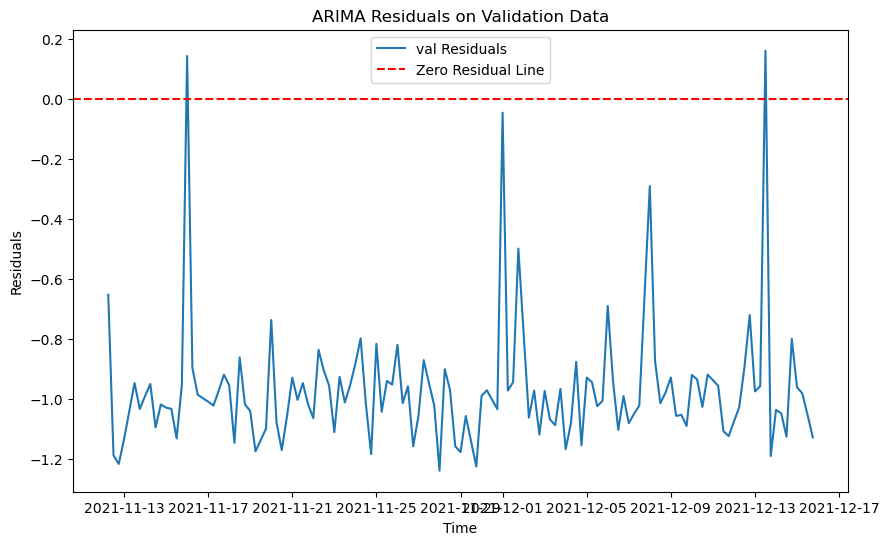

21:04:04 - cmdstanpy - INFO - Chain [1] start processing
21:04:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.35761828195565654
RMSE on validation data for ARIMA: 0.9899247424870447
RMSE on test data for ARIMA: 0.3975753741931487


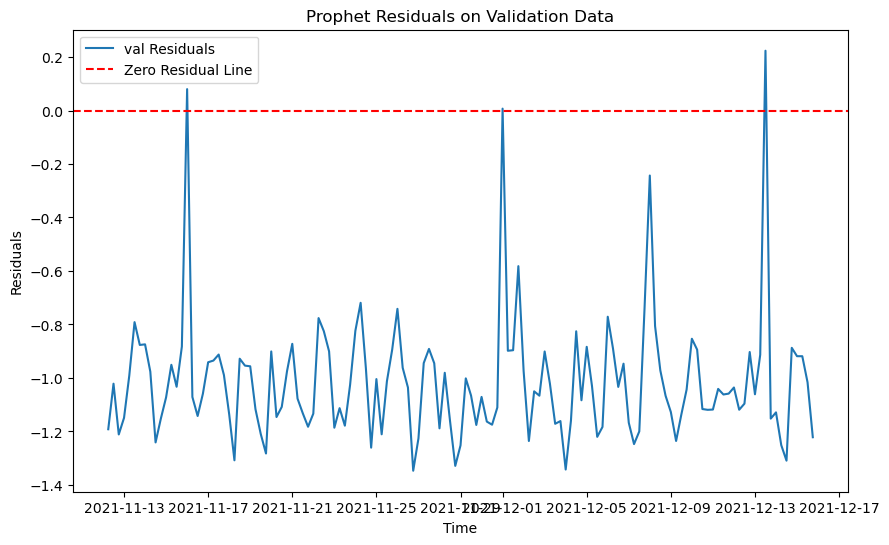

RMSE on training data for Prophet: 0.366568391067124
RMSE on validation data for Prophet: 1.0395488282189451
RMSE on test data for Prophet: 0.4110879441218985


<Figure size 1000x800 with 0 Axes>

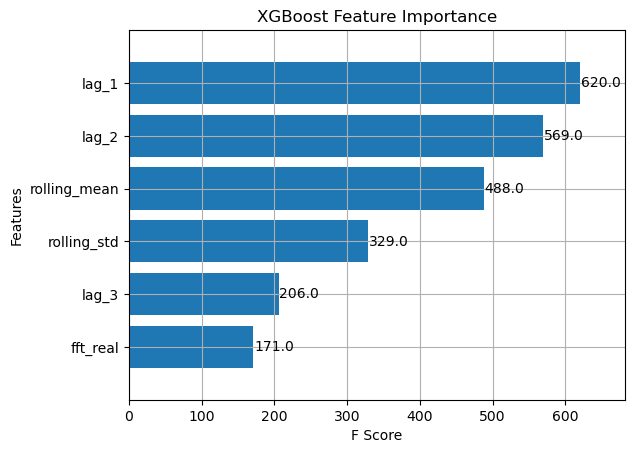

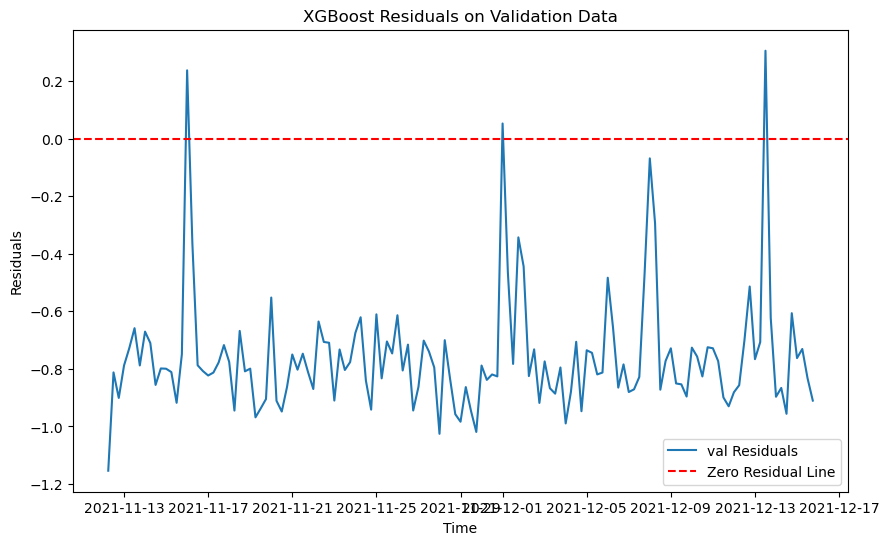

RMSE on training data for XGBoost: 0.01634982952698226
RMSE on validation data for XGBoost: 0.7858387670845941
RMSE on test data for XGBoost: 0.16283140176474306


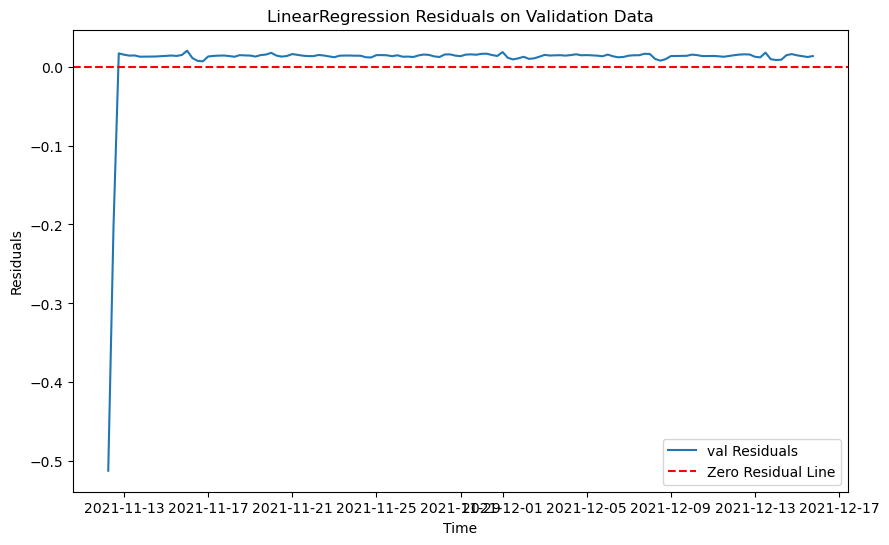

RMSE on training data for LinearRegression: 0.03480308492348234
RMSE on validation data for LinearRegression: 0.04928464028646512
RMSE on test data for LinearRegression: 0.011636154659754186

Best model is LinearRegression with RMSE: 0.04928464028646512
Best model saved as: models\model_110.pkl
data num 4
train_115.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 4.6229245283021666e-26
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.0826313760074208e-10
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 4.006675658476019e-15
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

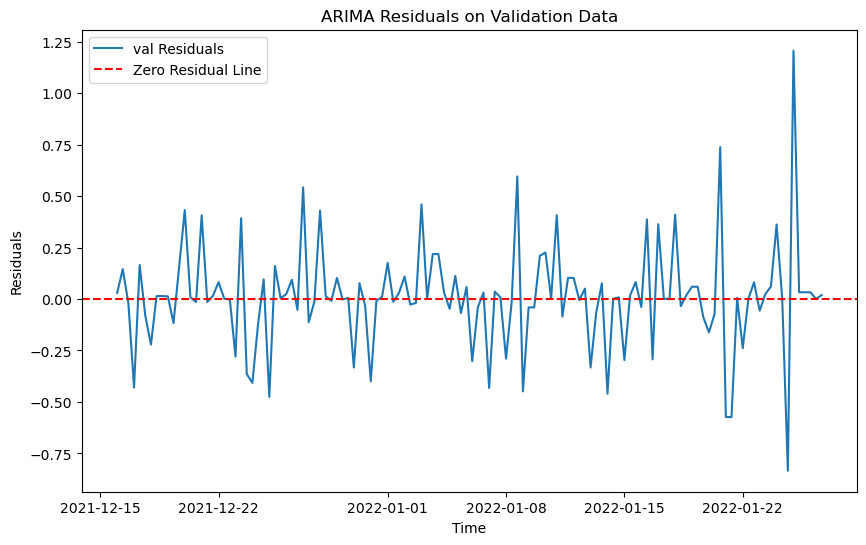

21:04:06 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.2743838182026247
RMSE on validation data for ARIMA: 0.25894666475968775
RMSE on test data for ARIMA: 0.2569331795259362


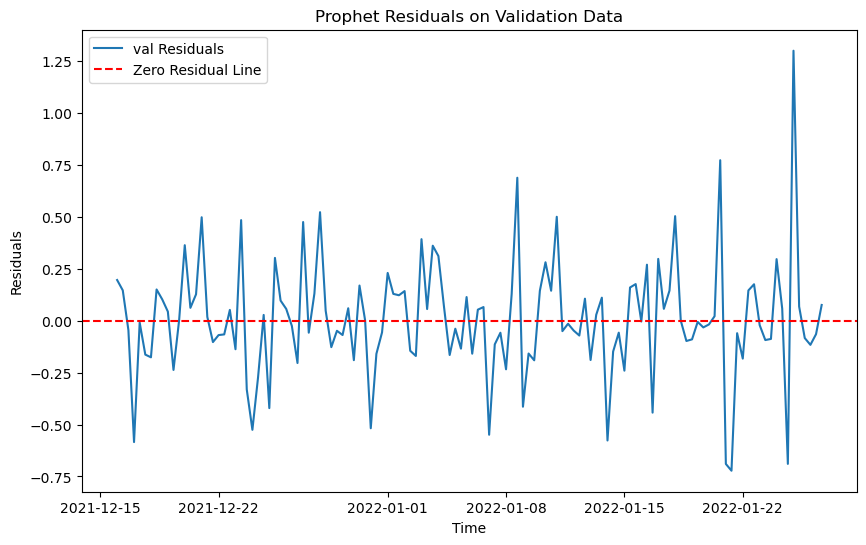

RMSE on training data for Prophet: 0.2795825452561712
RMSE on validation data for Prophet: 0.2848920635720826
RMSE on test data for Prophet: 0.27309793053898124


<Figure size 1000x800 with 0 Axes>

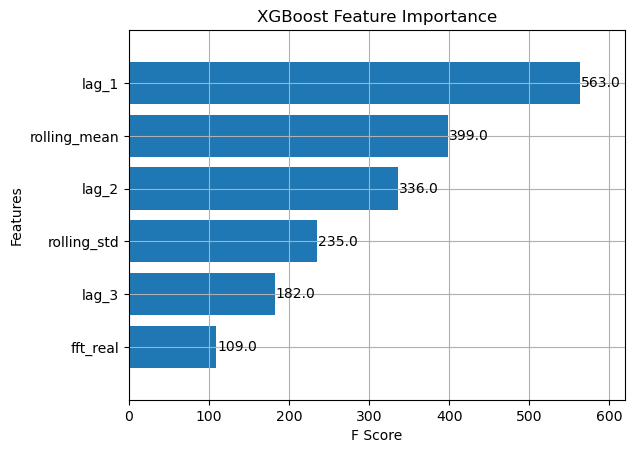

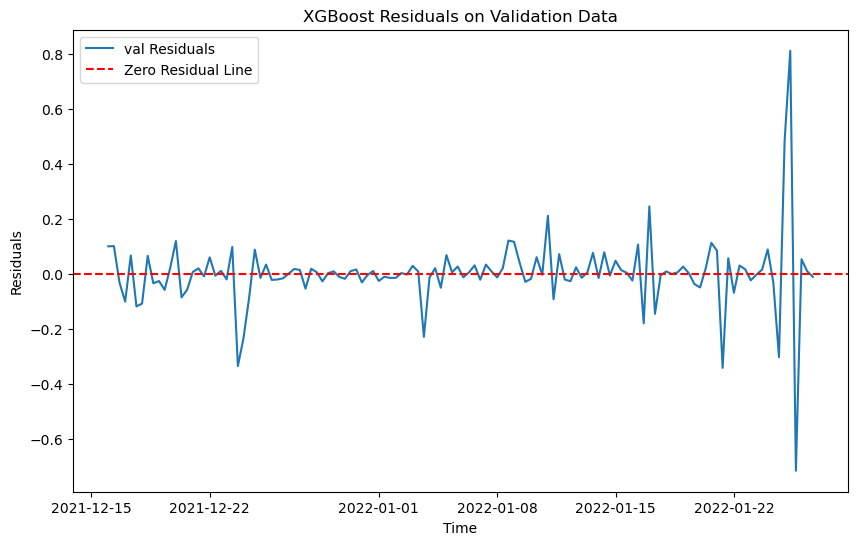

RMSE on training data for XGBoost: 0.015428097630217623
RMSE on validation data for XGBoost: 0.1338158690726724
RMSE on test data for XGBoost: 0.17458672224485325


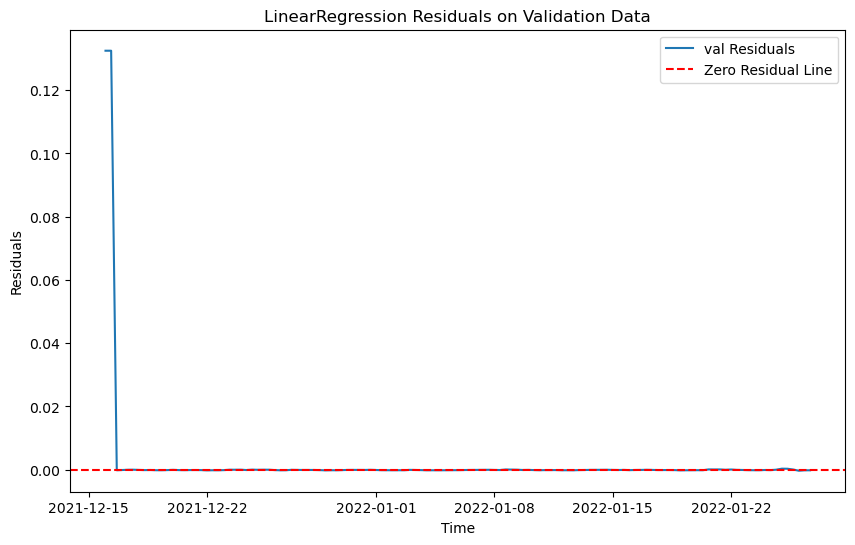

RMSE on training data for LinearRegression: 0.0014480200639133125
RMSE on validation data for LinearRegression: 0.016691999989631254
RMSE on test data for LinearRegression: 0.01703449658932152

Best model is LinearRegression with RMSE: 0.016691999989631254
Best model saved as: models\model_115.pkl
data num 5
train_118.csv


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 0.0
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive

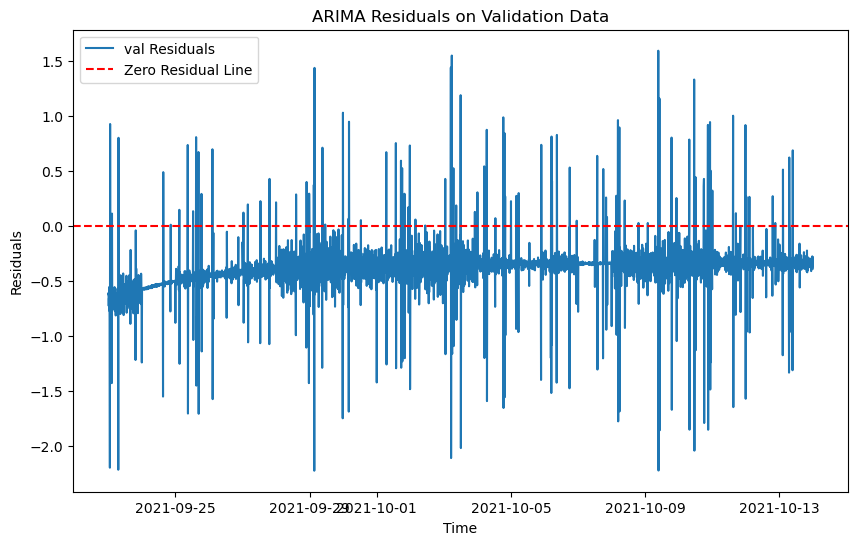

RMSE on training data for ARIMA: 0.2056154235187551
RMSE on validation data for ARIMA: 0.46800219780754126
RMSE on test data for ARIMA: 0.8542670496923991


21:04:16 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing


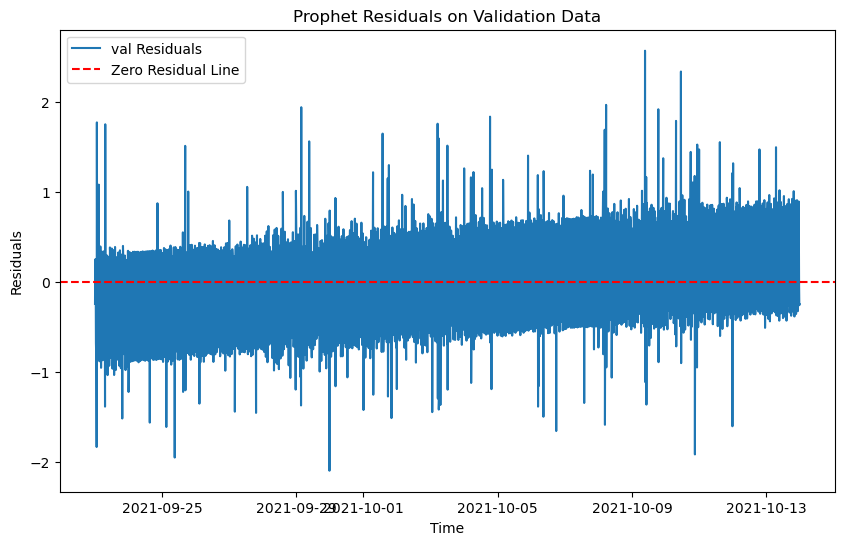

RMSE on training data for Prophet: 0.2215965282815207
RMSE on validation data for Prophet: 0.5382049762053792
RMSE on test data for Prophet: 0.763495415752379


<Figure size 1000x800 with 0 Axes>

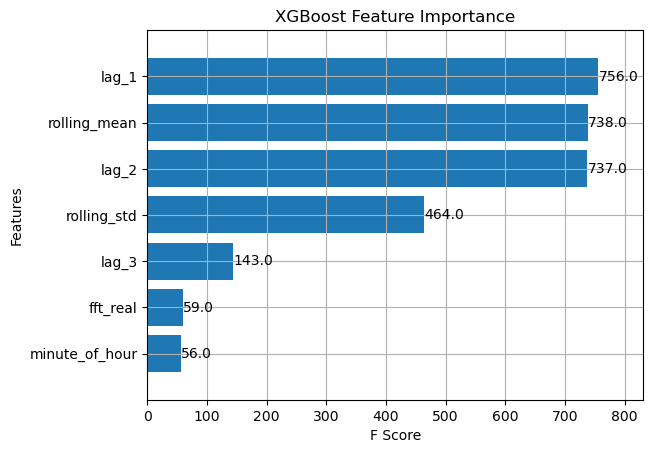

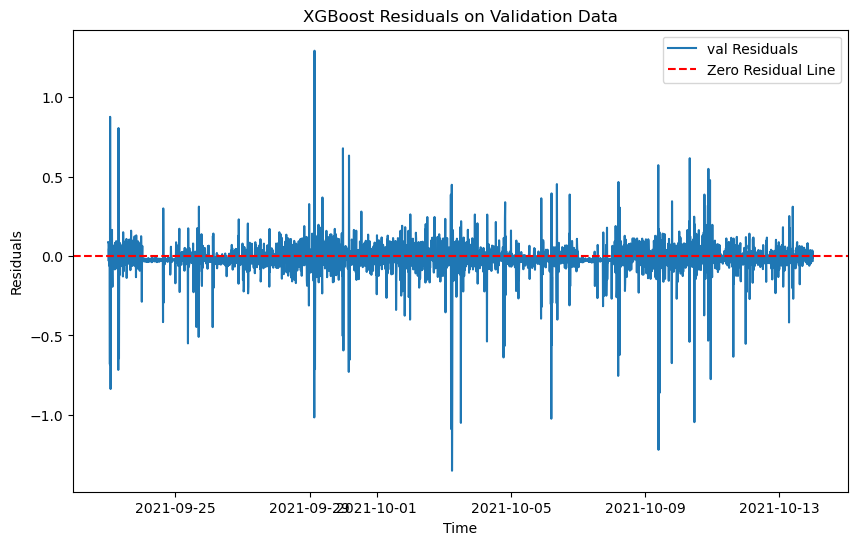

RMSE on training data for XGBoost: 0.029432457662483667
RMSE on validation data for XGBoost: 0.11968383371596364
RMSE on test data for XGBoost: 0.3142363145623324


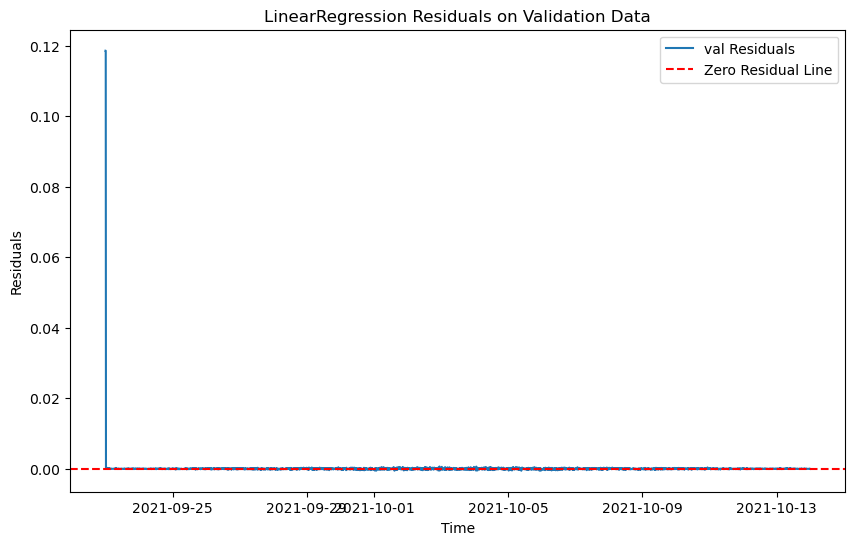

RMSE on training data for LinearRegression: 0.0012653486765555864
RMSE on validation data for LinearRegression: 0.003051849289174438
RMSE on test data for LinearRegression: 0.00043435050701207947

Best model is LinearRegression with RMSE: 0.003051849289174438
Best model saved as: models\model_118.pkl
data num 6
train_119.csv
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 2.6474352315036197e-11
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

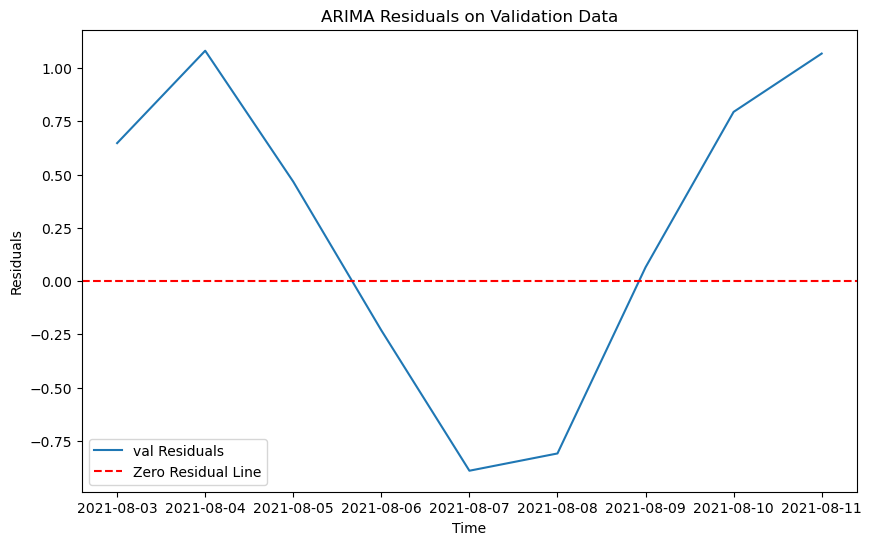

21:04:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.5325917152882206
RMSE on validation data for ARIMA: 0.7515595020993794
RMSE on test data for ARIMA: 0.5982832585925209


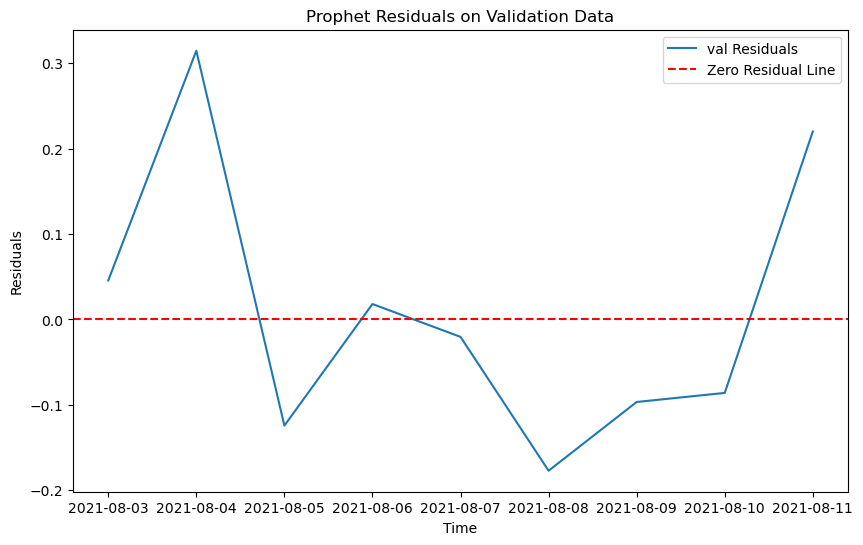

RMSE on training data for Prophet: 0.27211232094642196
RMSE on validation data for Prophet: 0.1541049679250987
RMSE on test data for Prophet: 1.2293390723651125


<Figure size 1000x800 with 0 Axes>

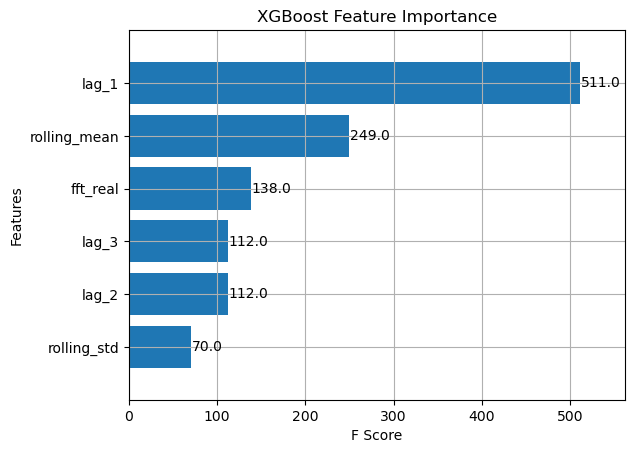

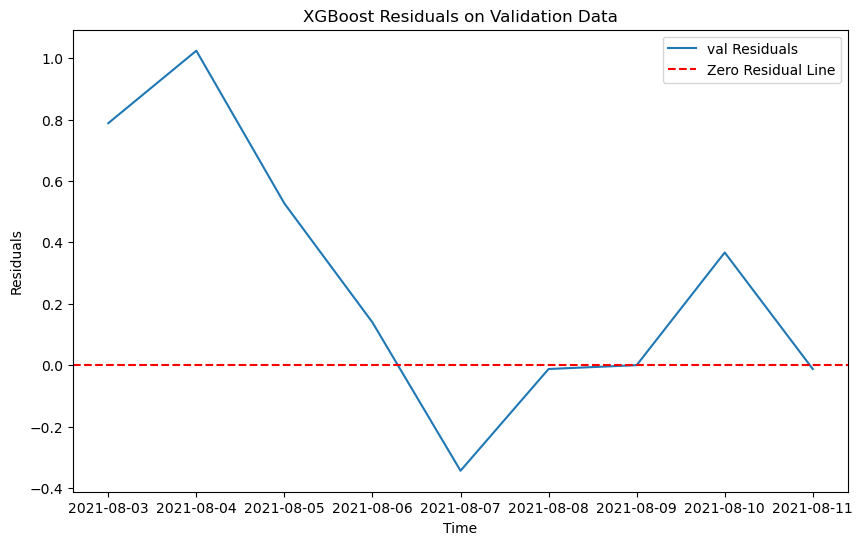

RMSE on training data for XGBoost: 0.0017680658983750955
RMSE on validation data for XGBoost: 0.4967930275716209
RMSE on test data for XGBoost: 0.47710544788149706


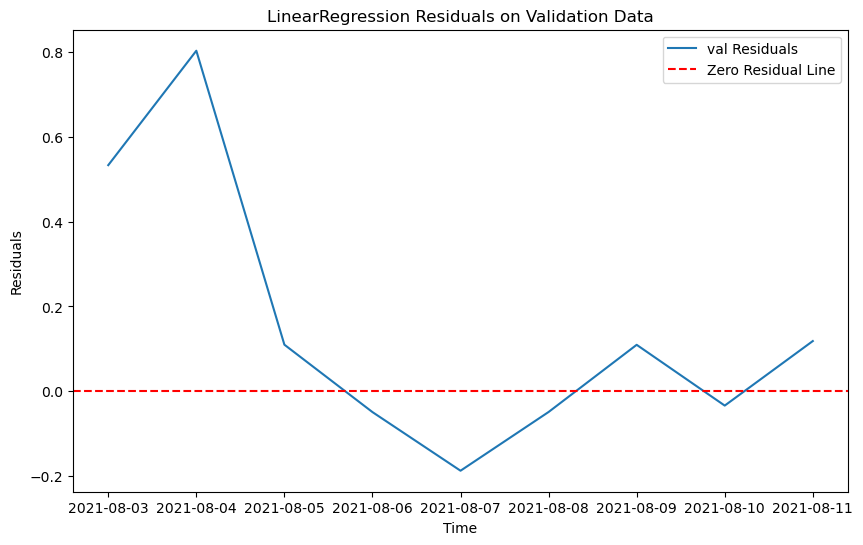

RMSE on training data for LinearRegression: 0.3416980407067438
RMSE on validation data for LinearRegression: 0.33457739904755246
RMSE on test data for LinearRegression: 0.1466620080947471

Best model is Prophet with RMSE: 0.1541049679250987
Best model saved as: models\model_119.pkl
data num 7
train_12.csv


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')


The differenced time series is stationary.
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


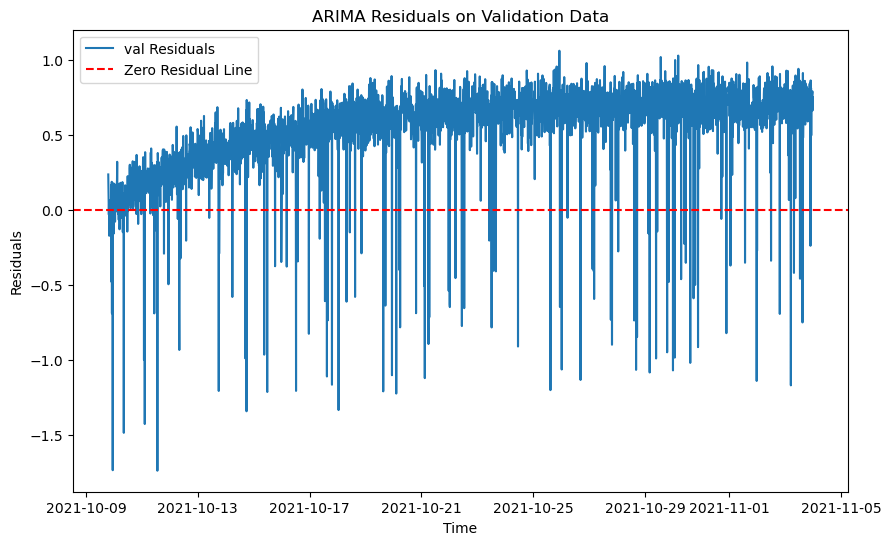

RMSE on training data for ARIMA: 0.2174104552728966
RMSE on validation data for ARIMA: 0.6192033548821393
RMSE on test data for ARIMA: 0.678125970429564


21:04:29 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing


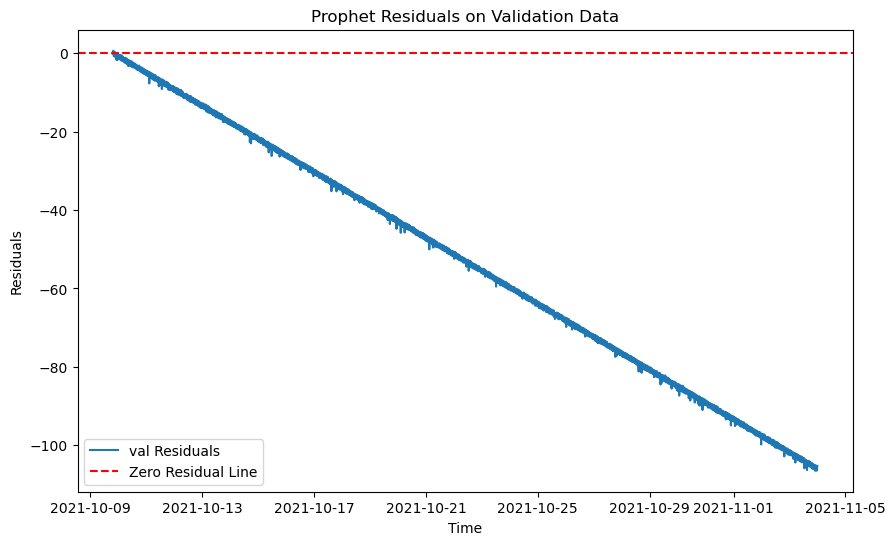

RMSE on training data for Prophet: 0.2898160146256992
RMSE on validation data for Prophet: 61.231517186390555
RMSE on test data for Prophet: 131.21676712820894


<Figure size 1000x800 with 0 Axes>

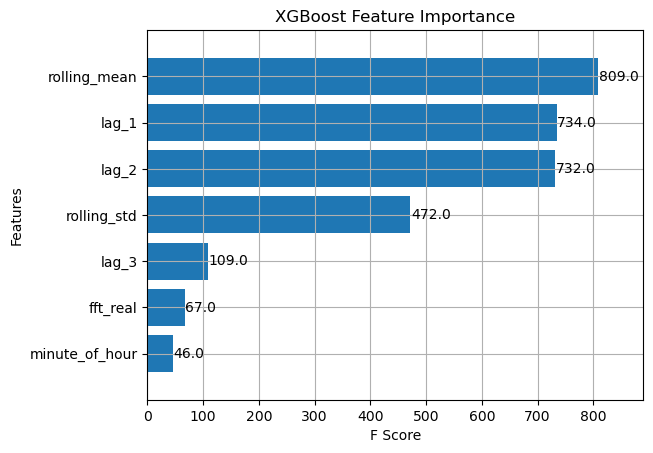

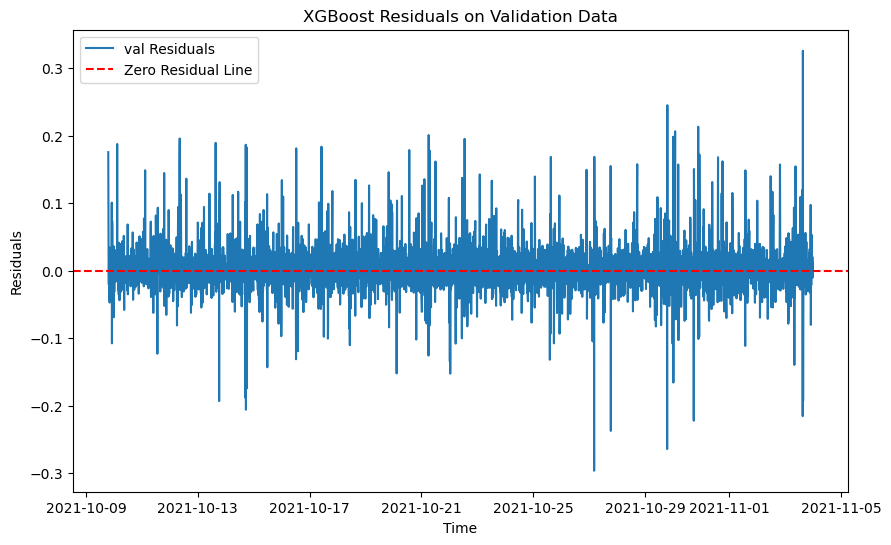

RMSE on training data for XGBoost: 0.03547210221484271
RMSE on validation data for XGBoost: 0.038357249152575754
RMSE on test data for XGBoost: 0.04461885437162594


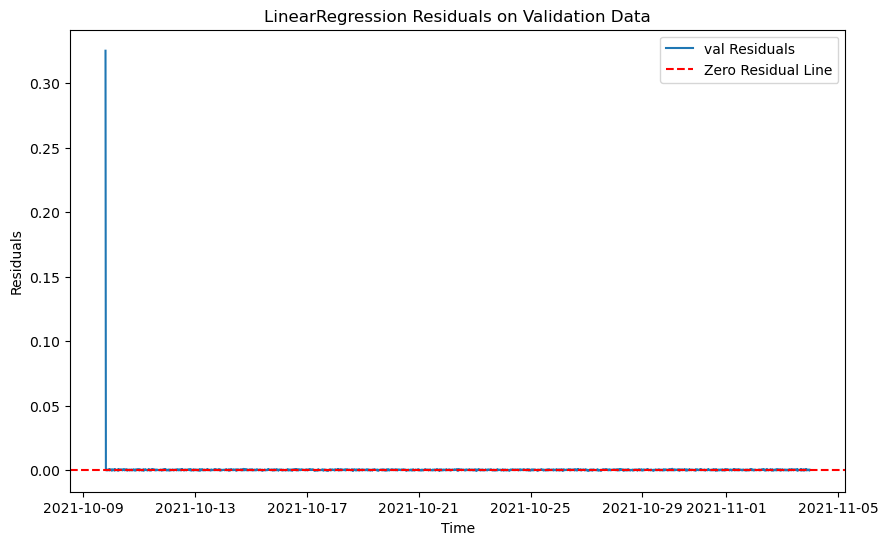

RMSE on training data for LinearRegression: 0.0010892898133803804
RMSE on validation data for LinearRegression: 0.006146722979912818
RMSE on test data for LinearRegression: 0.021465561861460758

Best model is LinearRegression with RMSE: 0.006146722979912818
Best model saved as: models\model_12.pkl
data num 8
train_131.csv


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

The time series is not stationary. Applying differencing 0


C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].diff().bfill()


New p-value after differencing: 0.0
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.1679070346539543e-26
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

The time series is not stationary. Applying differencing 0
New p-value after differencing: 0.0
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


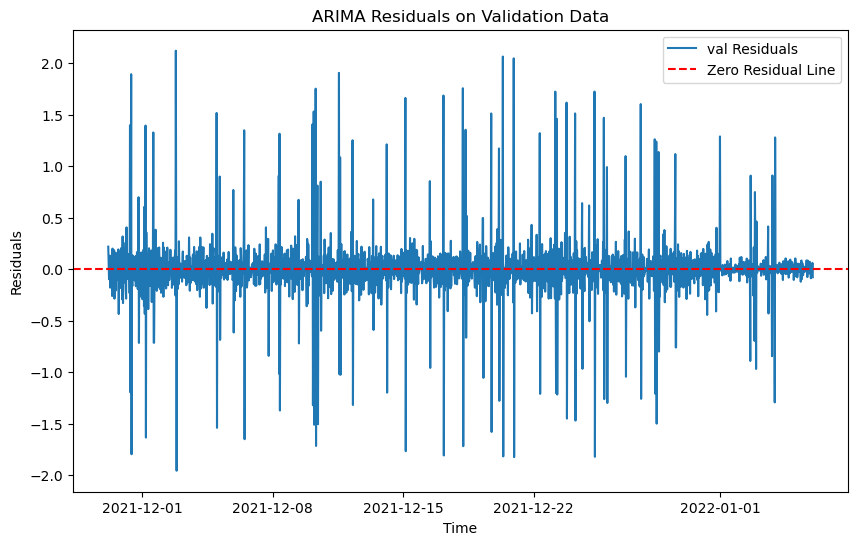

RMSE on training data for ARIMA: 0.2268457642097416
RMSE on validation data for ARIMA: 0.3479811770585257
RMSE on test data for ARIMA: 0.2958568915739024


21:04:43 - cmdstanpy - INFO - Chain [1] start processing
21:04:43 - cmdstanpy - INFO - Chain [1] done processing


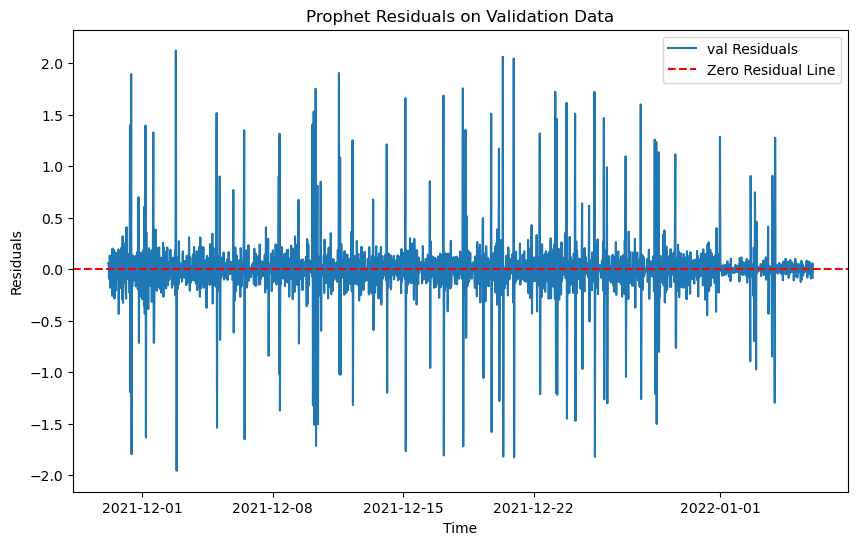

RMSE on training data for Prophet: 0.305841055223731
RMSE on validation data for Prophet: 0.34795107850527307
RMSE on test data for Prophet: 0.2958973159297588


<Figure size 1000x800 with 0 Axes>

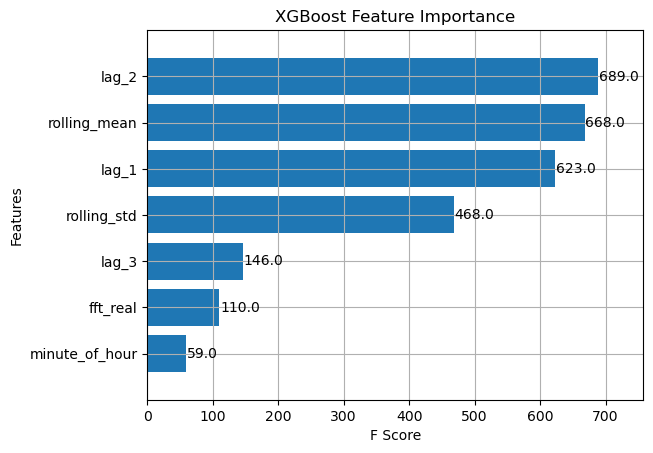

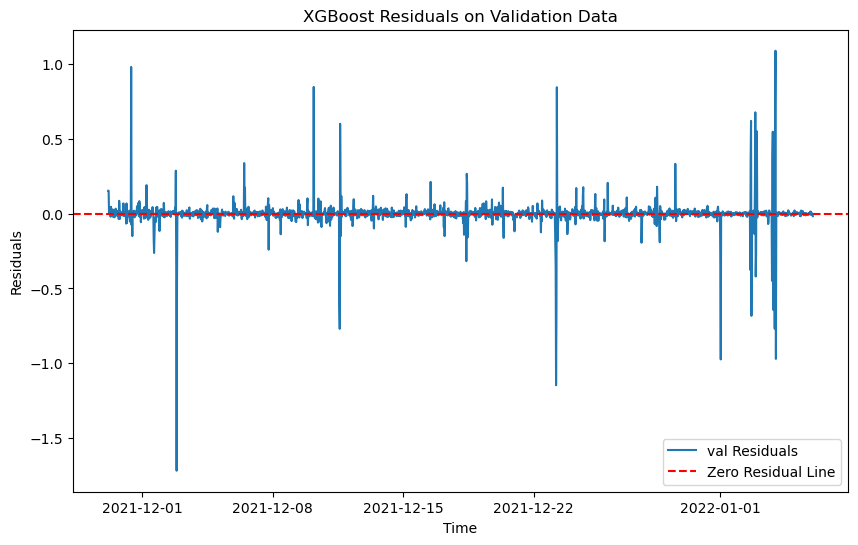

RMSE on training data for XGBoost: 0.020818962214881605
RMSE on validation data for XGBoost: 0.10263483349552893
RMSE on test data for XGBoost: 0.2611423527990864


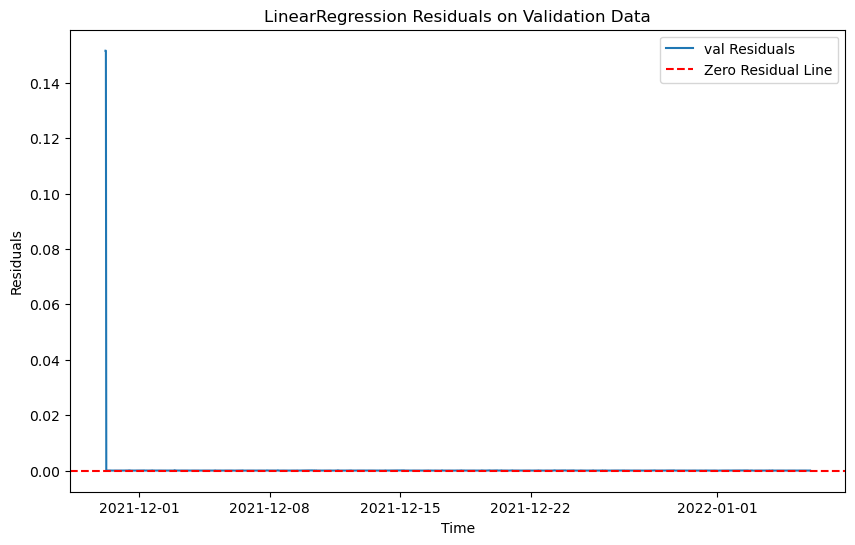

RMSE on training data for LinearRegression: 0.00047116374032790274
RMSE on validation data for LinearRegression: 0.005031697069239819
RMSE on test data for LinearRegression: 0.00466760591065385

Best model is LinearRegression with RMSE: 0.005031697069239819
Best model saved as: models\model_131.pkl
data num 9
train_141.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.5722228612801715e-22
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 3.3299980730924183e-21
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')
C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

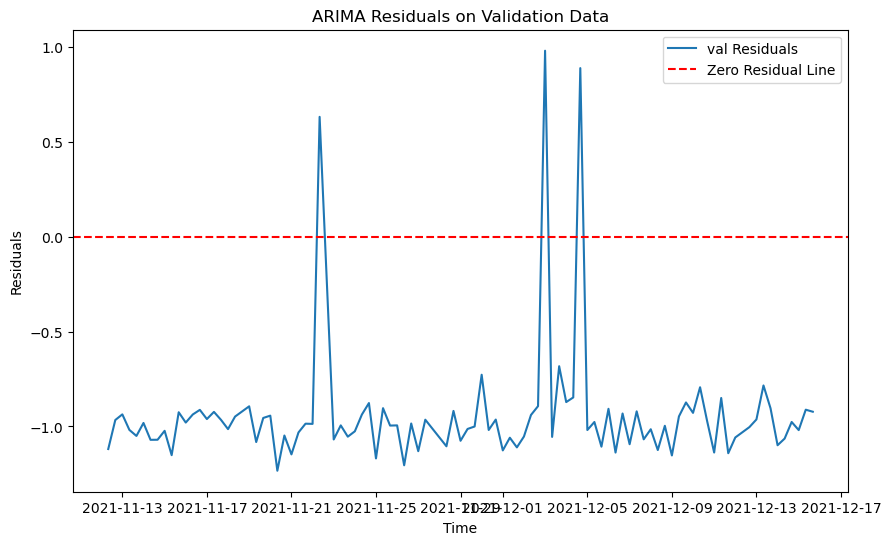

21:04:48 - cmdstanpy - INFO - Chain [1] start processing
21:04:48 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.2344032884558796
RMSE on validation data for ARIMA: 0.9938944959079901
RMSE on test data for ARIMA: 0.28190474227643825


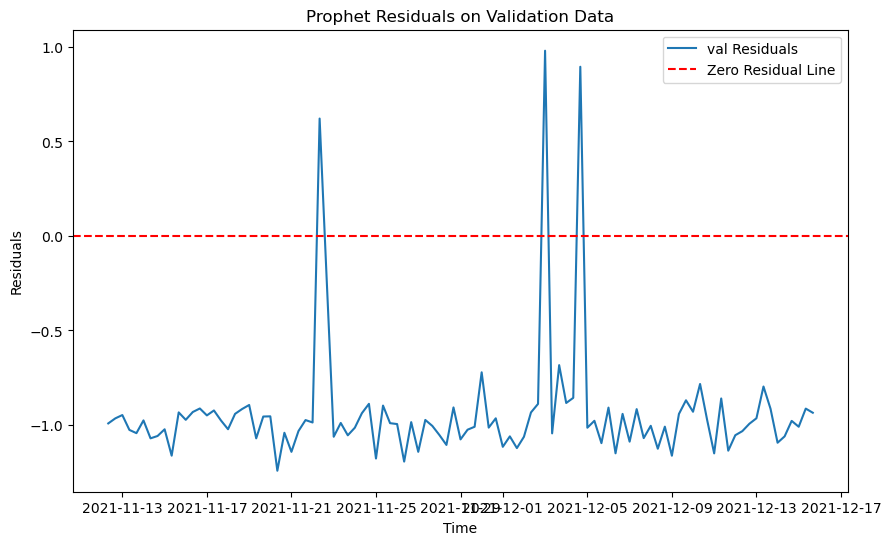

RMSE on training data for Prophet: 0.3100206229547175
RMSE on validation data for Prophet: 0.993077873605992
RMSE on test data for Prophet: 0.2810043111742809


<Figure size 1000x800 with 0 Axes>

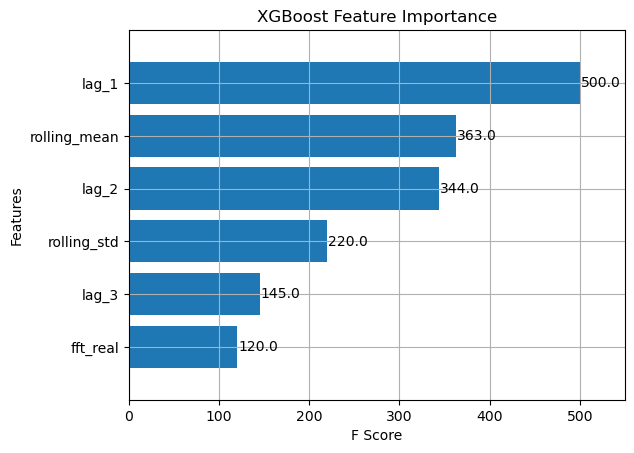

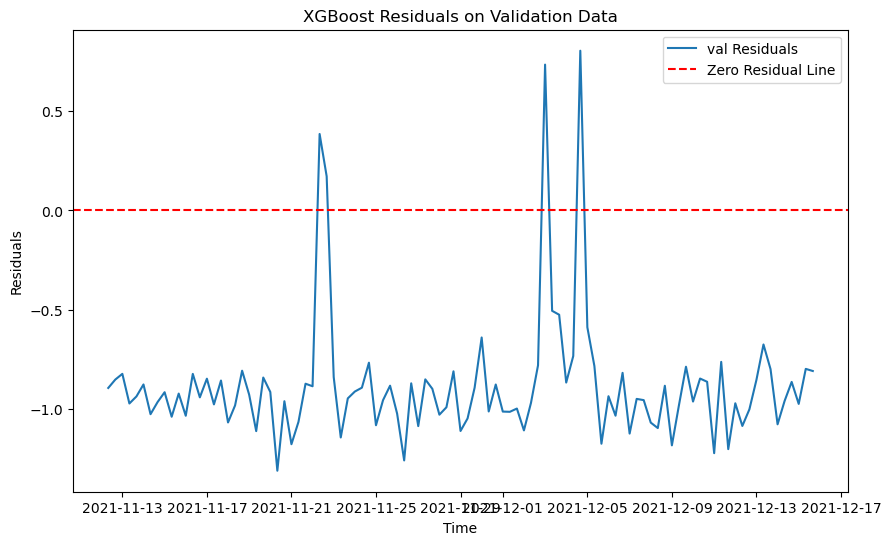

RMSE on training data for XGBoost: 0.009660434056106464
RMSE on validation data for XGBoost: 0.9362313522894515
RMSE on test data for XGBoost: 0.294955297212994


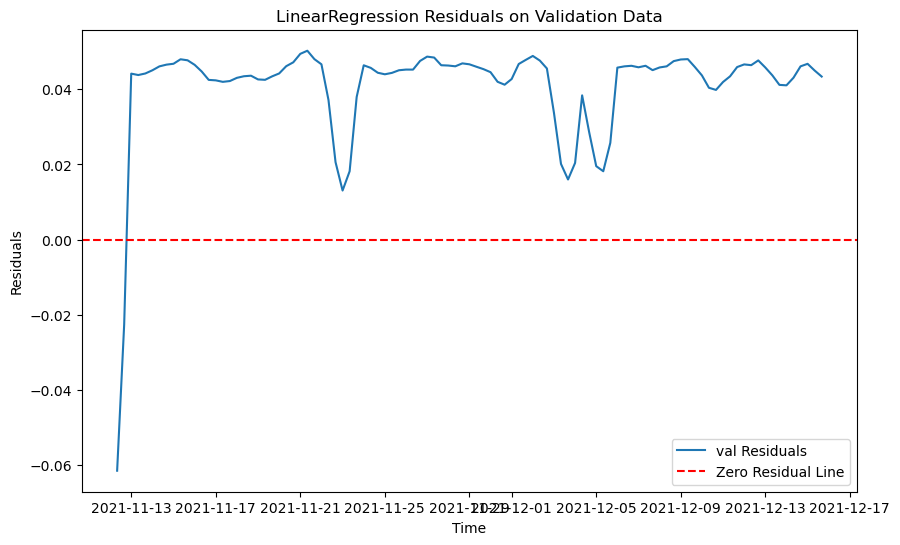

RMSE on training data for LinearRegression: 0.016464314377047002
RMSE on validation data for LinearRegression: 0.04318204613237923
RMSE on test data for LinearRegression: 0.029159417519817498

Best model is LinearRegression with RMSE: 0.04318204613237923
Best model saved as: models\model_141.pkl
data num 10
train_151.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 3.088575527262519e-20
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 3.4082278278763527e-09
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.4541230077620053e-11
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

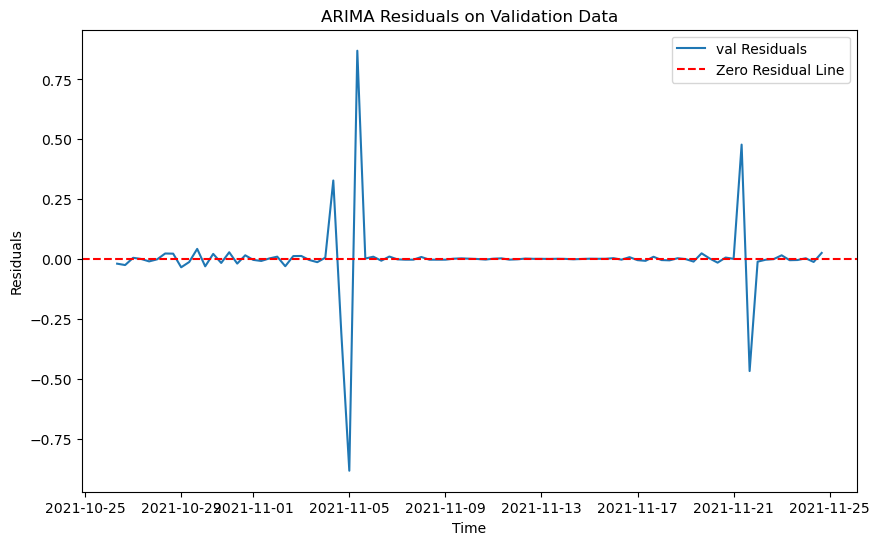

21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.2102976808258601
RMSE on validation data for ARIMA: 0.1571684026593518
RMSE on test data for ARIMA: 0.2642281427385585


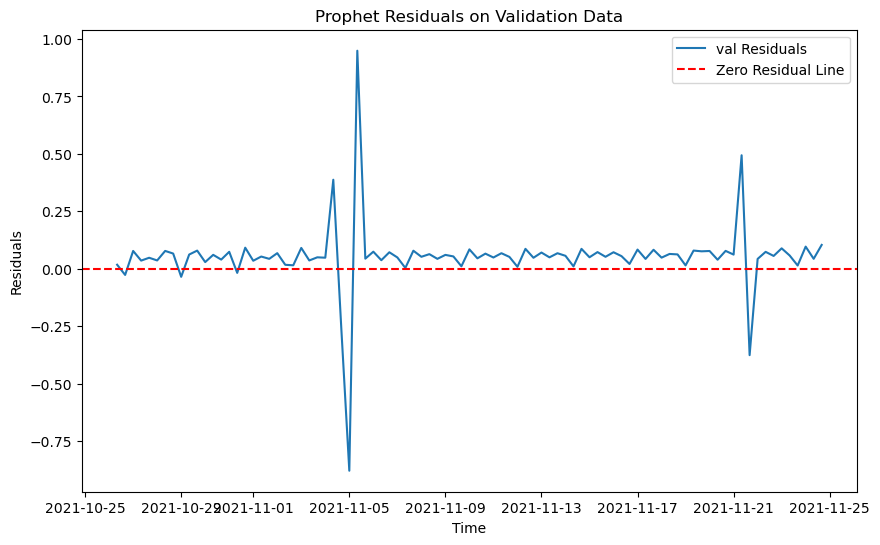

RMSE on training data for Prophet: 0.26746944061215644
RMSE on validation data for Prophet: 0.16986733023865538
RMSE on test data for Prophet: 0.27658798346313296


<Figure size 1000x800 with 0 Axes>

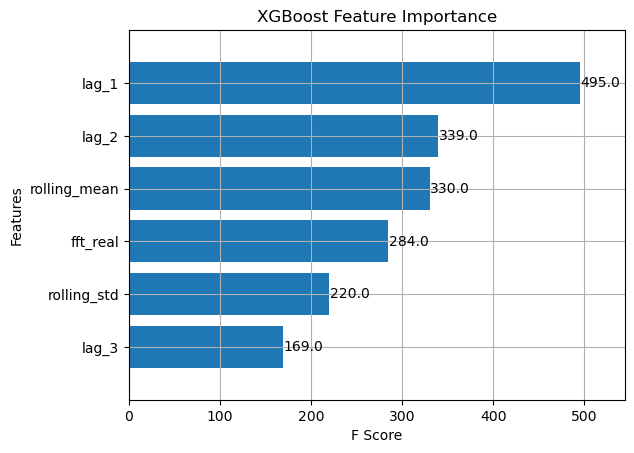

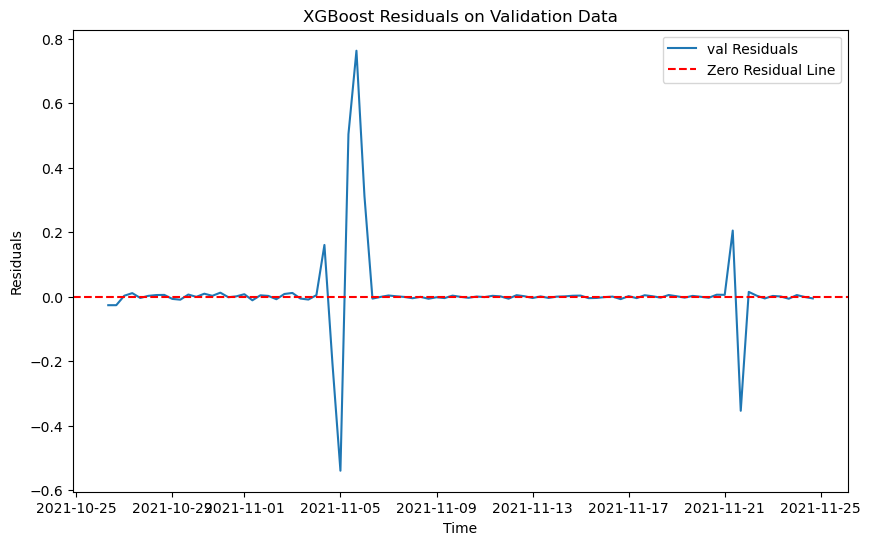

RMSE on training data for XGBoost: 0.006622545347201234
RMSE on validation data for XGBoost: 0.12825785082139501
RMSE on test data for XGBoost: 0.2503808352921585


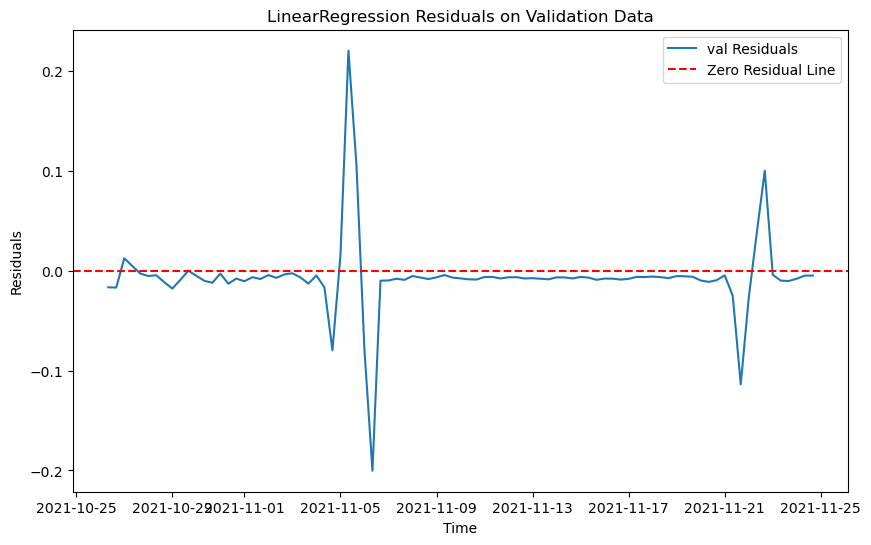

RMSE on training data for LinearRegression: 0.1227759330705701
RMSE on validation data for LinearRegression: 0.040239762035723846
RMSE on test data for LinearRegression: 0.07010115900719889

Best model is LinearRegression with RMSE: 0.040239762035723846
Best model saved as: models\model_151.pkl
data num 11
train_153.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.0776802772479312e-12
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 1.7716559336733767e-17
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

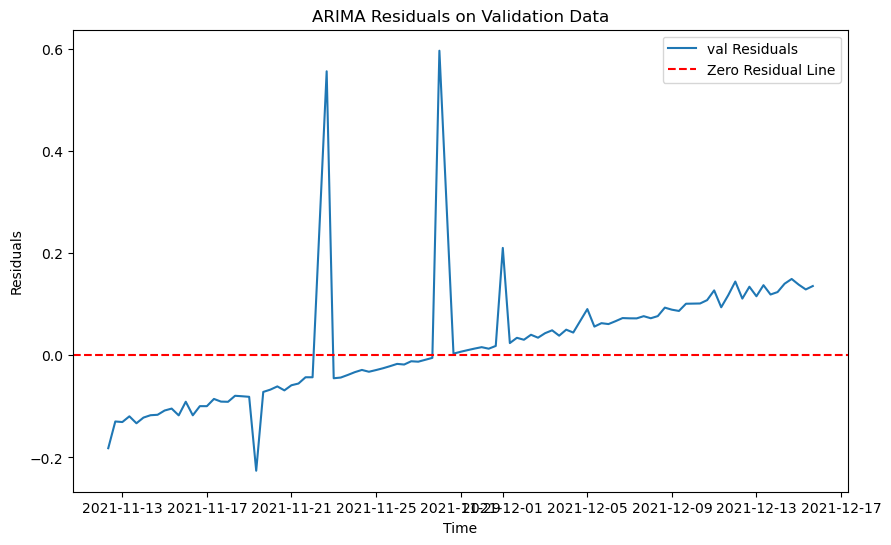

21:04:52 - cmdstanpy - INFO - Chain [1] start processing
21:04:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.1865953247106351
RMSE on validation data for ARIMA: 0.12641499985873877
RMSE on test data for ARIMA: 0.2591420804008397


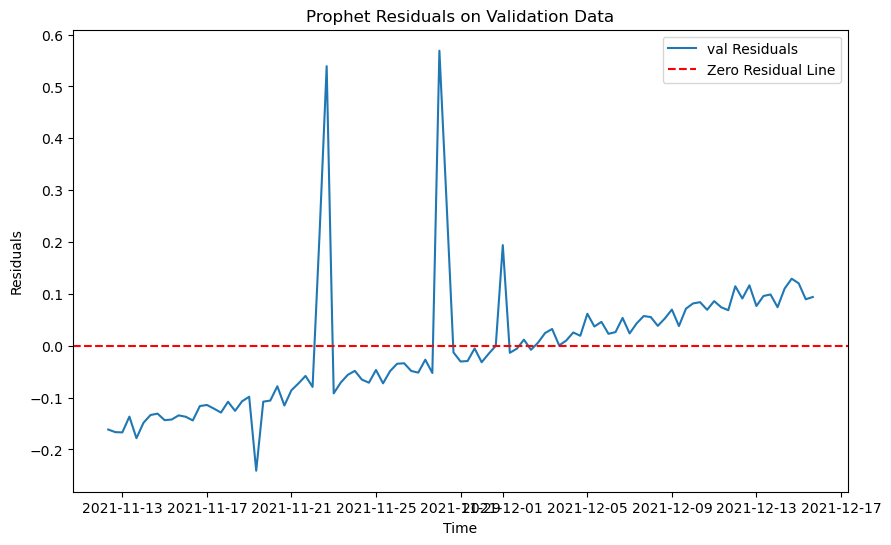

RMSE on training data for Prophet: 0.25286331902601067
RMSE on validation data for Prophet: 0.12383443147458532
RMSE on test data for Prophet: 0.26129044746690006


<Figure size 1000x800 with 0 Axes>

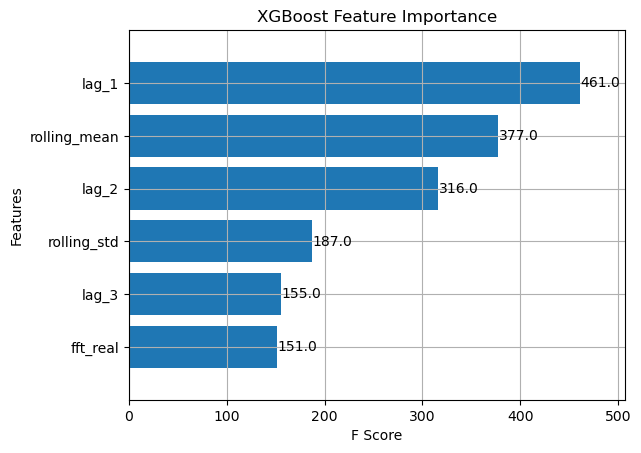

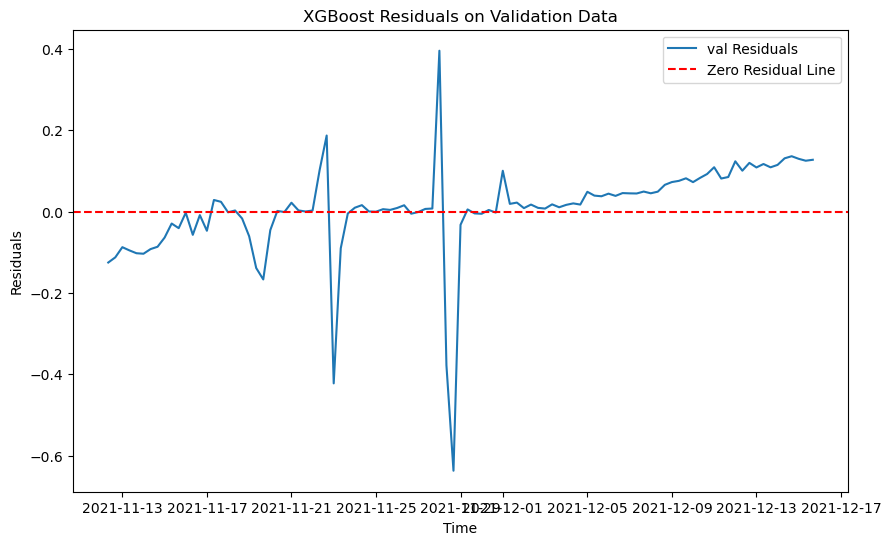

RMSE on training data for XGBoost: 0.00804179092497802
RMSE on validation data for XGBoost: 0.11637379950218849
RMSE on test data for XGBoost: 0.24578237315162754


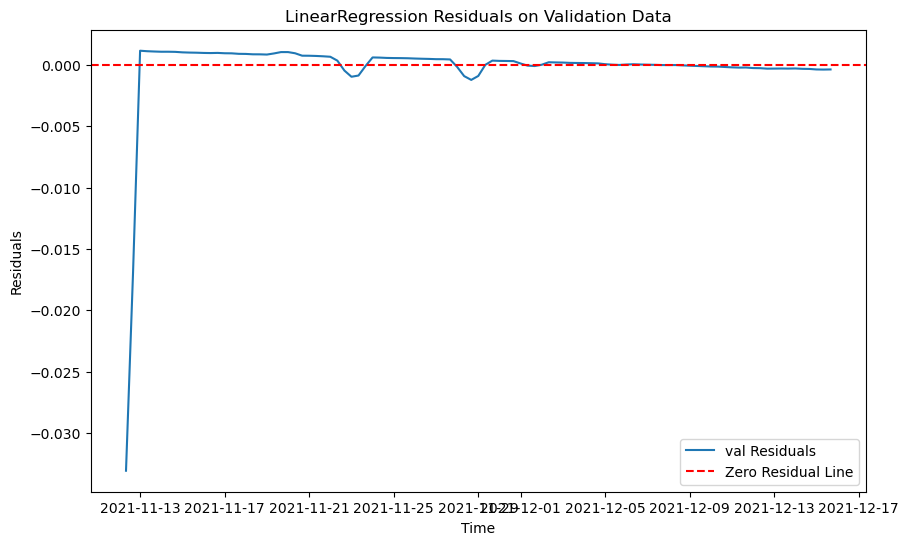

RMSE on training data for LinearRegression: 0.005090935819458792
RMSE on validation data for LinearRegression: 0.0037445673938879694
RMSE on test data for LinearRegression: 0.002208316850778929

Best model is LinearRegression with RMSE: 0.0037445673938879694
Best model saved as: models\model_153.pkl
data num 12
train_155.csv


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')


The time series is not stationary. Applying differencing 0


C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].diff().bfill()


New p-value after differencing: 0.0
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

New p-value after differencing: 4.4965227706509085e-29
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

The time series is not stationary. Applying differencing 0
New p-value after differencing: 0.0
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\mohamed\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

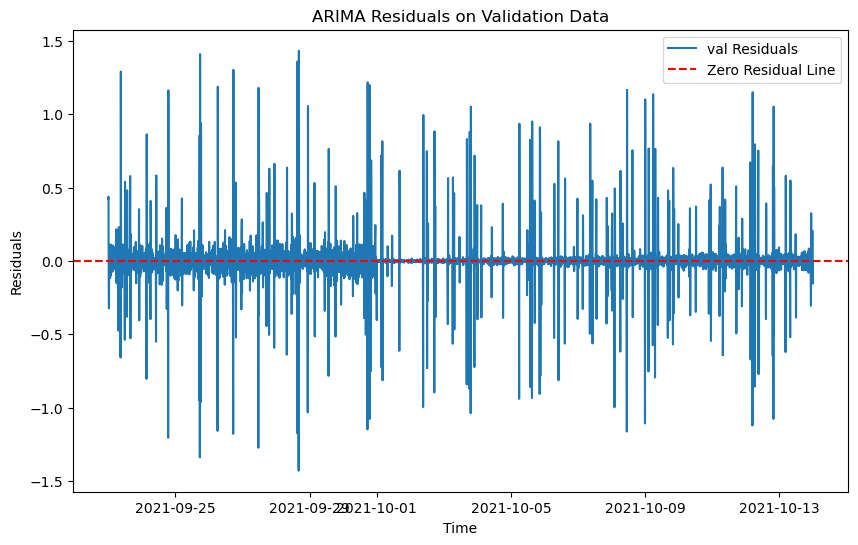

RMSE on training data for ARIMA: 0.1691298499477293
RMSE on validation data for ARIMA: 0.19819069322556687
RMSE on test data for ARIMA: 0.2844691147339282


21:05:07 - cmdstanpy - INFO - Chain [1] start processing
21:05:08 - cmdstanpy - INFO - Chain [1] done processing


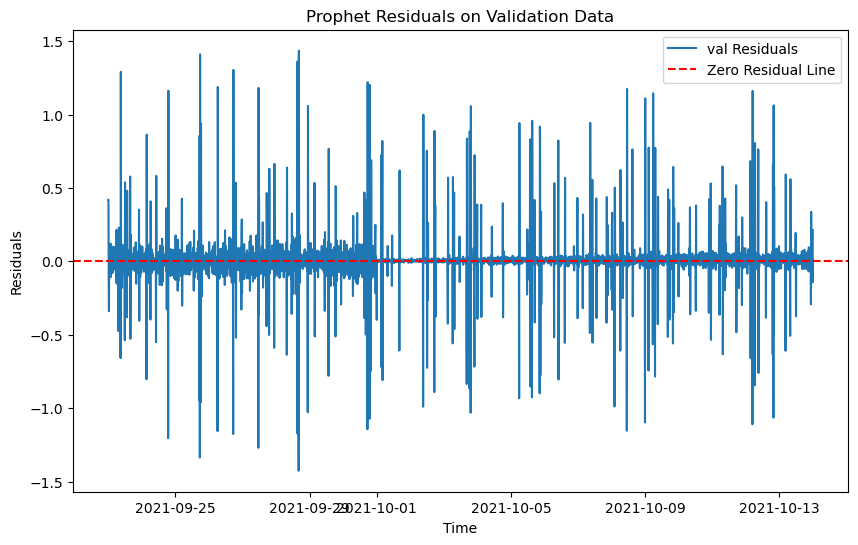

RMSE on training data for Prophet: 0.23289254507307997
RMSE on validation data for Prophet: 0.1983029214688241
RMSE on test data for Prophet: 0.28489073172644297


<Figure size 1000x800 with 0 Axes>

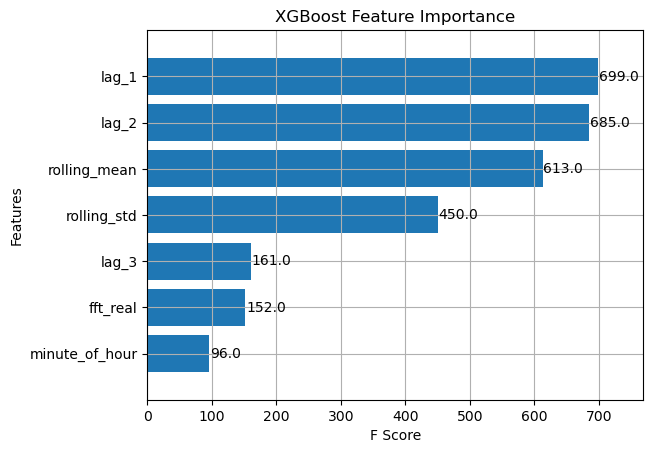

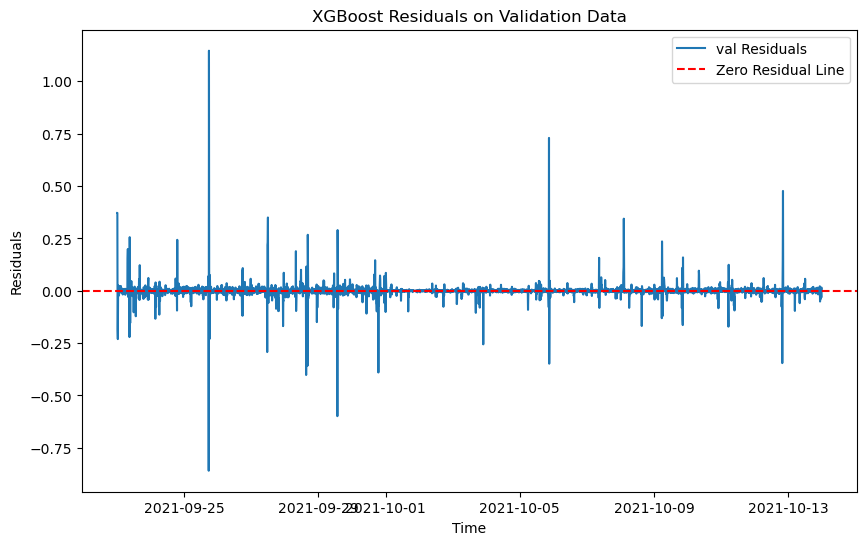

RMSE on training data for XGBoost: 0.019216322682780323
RMSE on validation data for XGBoost: 0.04673663418951789
RMSE on test data for XGBoost: 0.1071041850130818


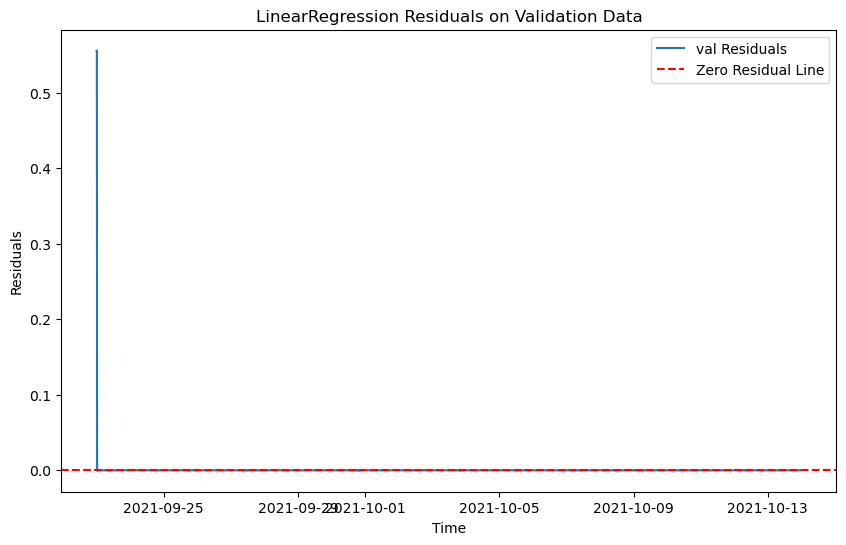

RMSE on training data for LinearRegression: 0.0020299834947237446
RMSE on validation data for LinearRegression: 0.014285503723347503
RMSE on test data for LinearRegression: 0.0013903387762600609

Best model is LinearRegression with RMSE: 0.014285503723347503
Best model saved as: models\model_155.pkl
data num 13
train_161.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 0.0
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')
C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

The differenced time series is stationary.
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\1740908248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_hour'] = df.index.minute
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['value'].shift(lag)
C:\Windows\Temp\ipykernel_19408\1740908248.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

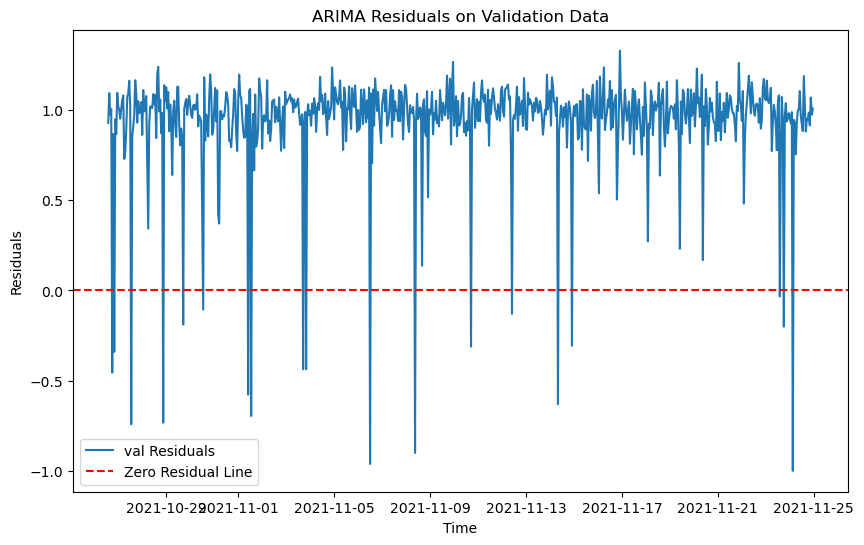

21:05:17 - cmdstanpy - INFO - Chain [1] start processing


RMSE on training data for ARIMA: 0.2316471299797256
RMSE on validation data for ARIMA: 0.9866287975176323
RMSE on test data for ARIMA: 0.9409239610934889


21:05:17 - cmdstanpy - INFO - Chain [1] done processing


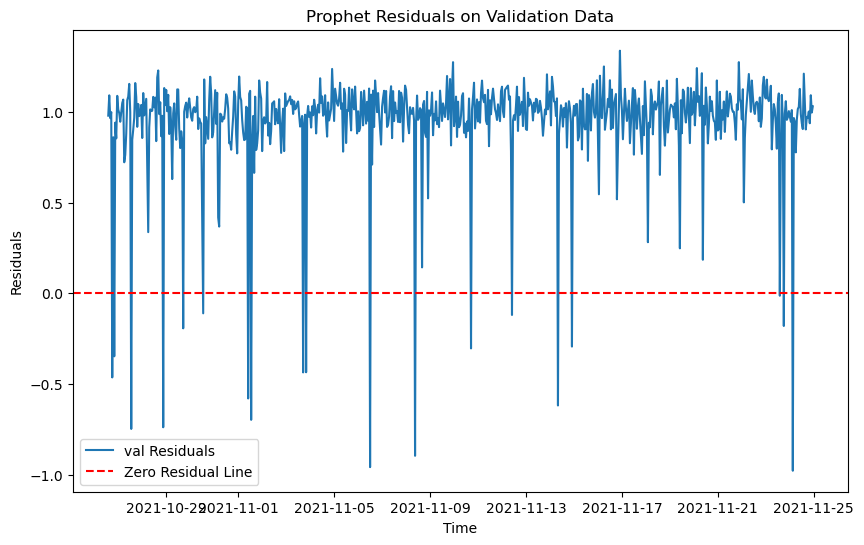

RMSE on training data for Prophet: 0.2987438296678054
RMSE on validation data for Prophet: 0.9926174349680038
RMSE on test data for Prophet: 0.96259795000318


<Figure size 1000x800 with 0 Axes>

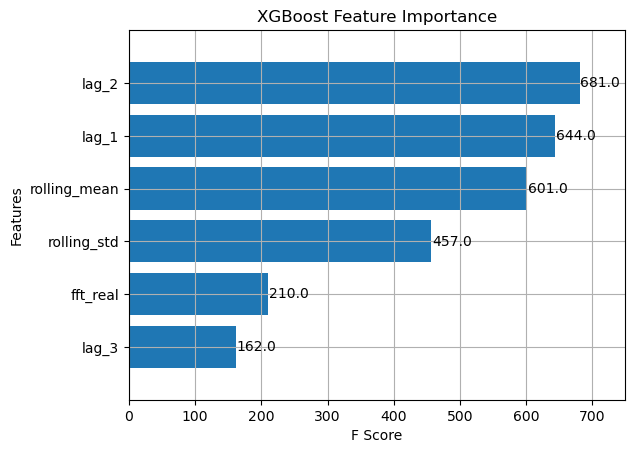

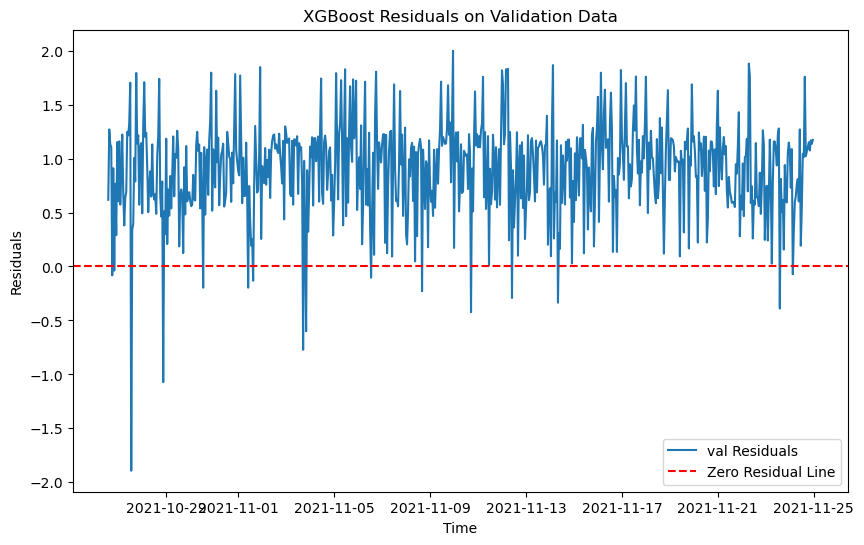

RMSE on training data for XGBoost: 0.018955195822326038
RMSE on validation data for XGBoost: 0.9994490989675563
RMSE on test data for XGBoost: 0.9387063323356244


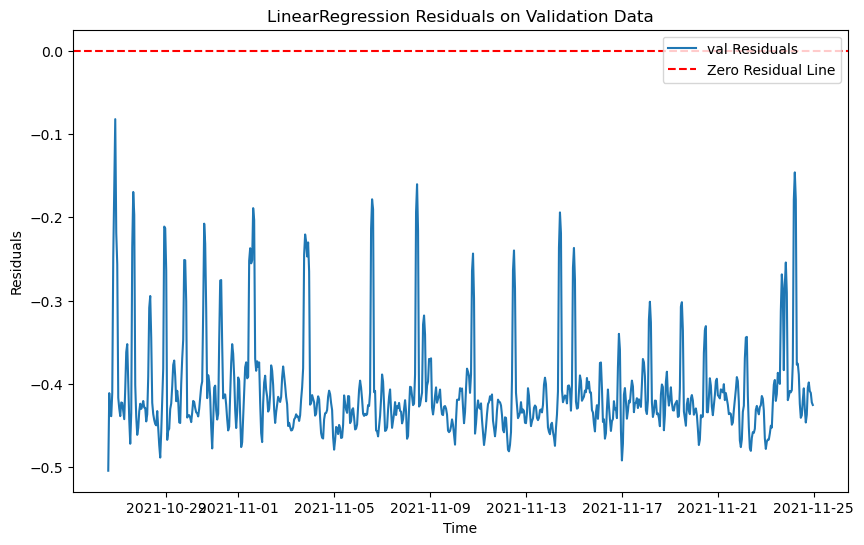

RMSE on training data for LinearRegression: 0.08949750982161617
RMSE on validation data for LinearRegression: 0.4125052618136986
RMSE on test data for LinearRegression: 0.3950418669144401

Best model is LinearRegression with RMSE: 0.4125052618136986
Best model saved as: models\model_161.pkl
data num 14
train_165.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 2.849408438635993e-28
The differenced time series is stationary.
The differenced time series is stationary.
The time series is not stationary. Applying differencing 0
New p-value after differencing: 3.2987260371711966e-23
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('anomaly', axis=1, inplace=True)
C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

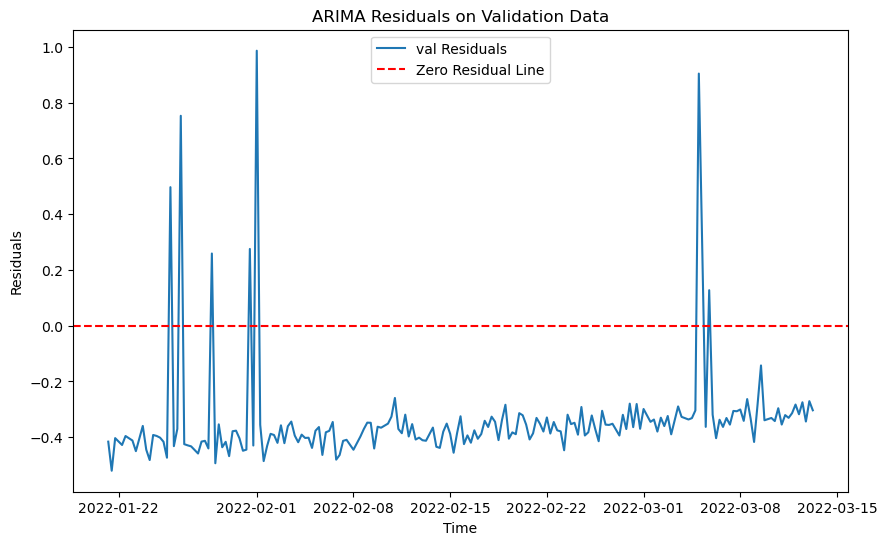

21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE on training data for ARIMA: 0.27158201802028703
RMSE on validation data for ARIMA: 0.38826591620853207
RMSE on test data for ARIMA: 0.29530940509613435


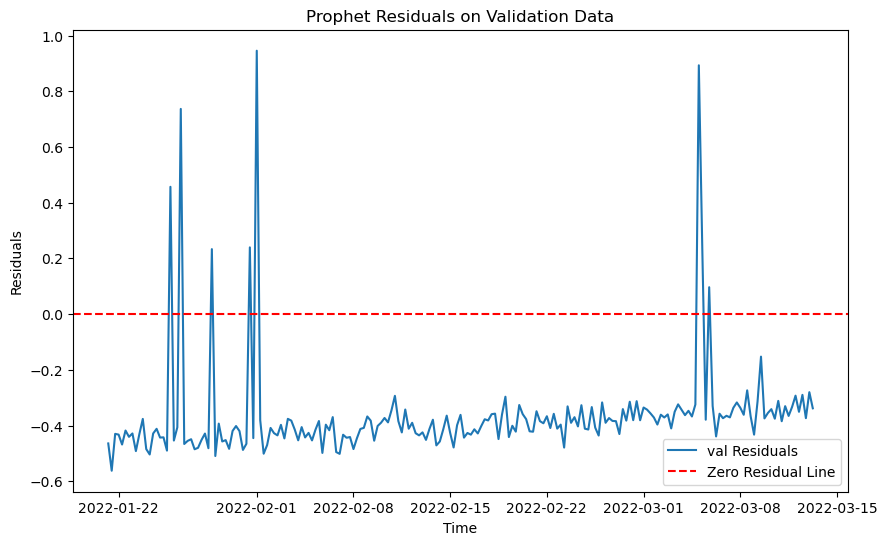

RMSE on training data for Prophet: 0.3689971090107548
RMSE on validation data for Prophet: 0.4109327397893934
RMSE on test data for Prophet: 0.29519028071619846


<Figure size 1000x800 with 0 Axes>

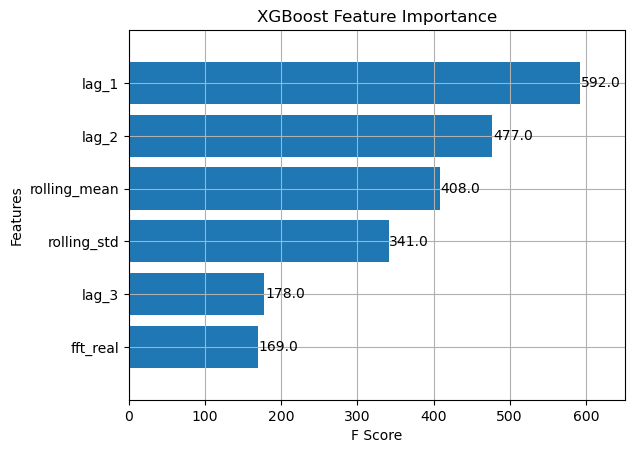

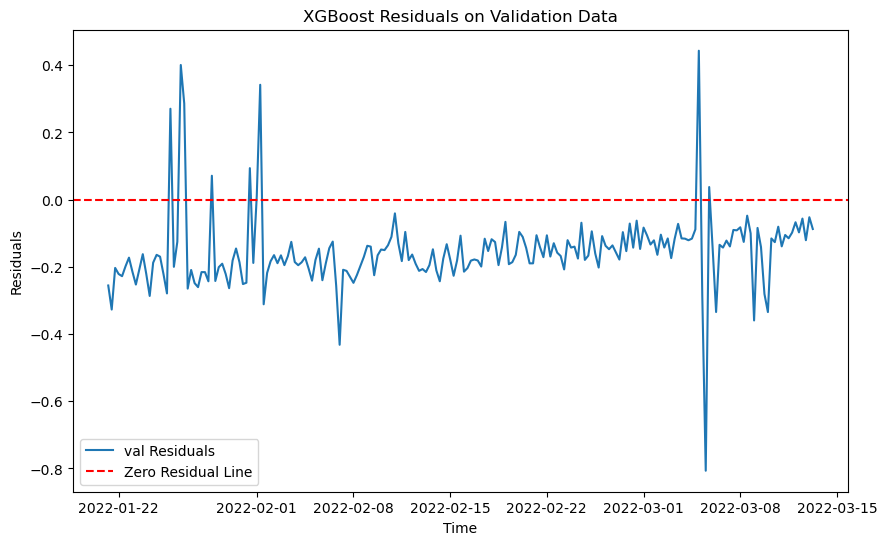

RMSE on training data for XGBoost: 0.015763871497333336
RMSE on validation data for XGBoost: 0.1925452164196743
RMSE on test data for XGBoost: 0.29714779142307907


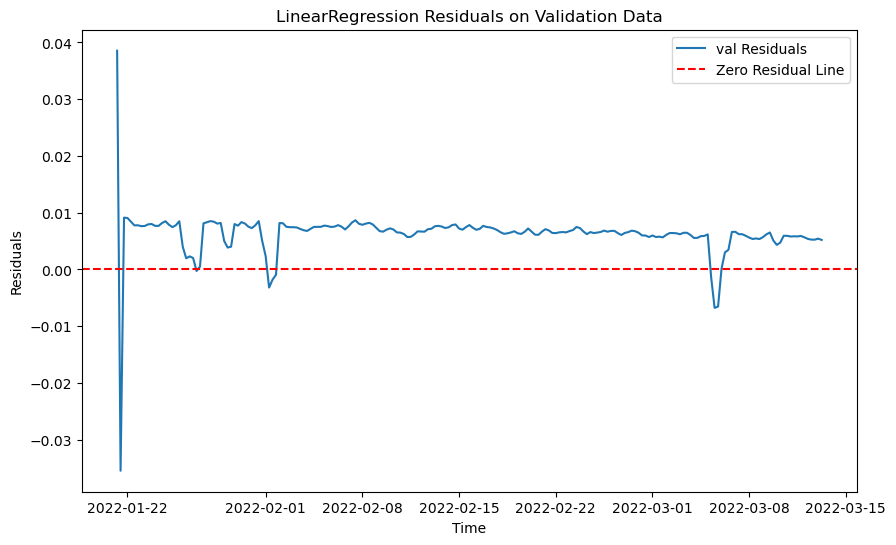

RMSE on training data for LinearRegression: 0.019534682807402635
RMSE on validation data for LinearRegression: 0.007607077935507935
RMSE on test data for LinearRegression: 0.009838075623309205

Best model is LinearRegression with RMSE: 0.007607077935507935
Best model saved as: models\model_165.pkl
data num 15
train_176.csv
The time series is not stationary. Applying differencing 0
New p-value after differencing: 4.981473119028948e-13
The differenced time series is stationary.
The differenced time series is stationary.


C:\Windows\Temp\ipykernel_19408\3954895328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Windows\Temp\ipykernel_19408\3954895328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].interpolate(method='linear')
C:\Windows\Temp\ipykernel_19408\3954895328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

MissingDataError: exog contains inf or nans

In [32]:
folder_path = 'train_splits'
cnt=0

for filename in os.listdir(folder_path):
    
    if filename.endswith('.csv'):
        print(filename)
        train_file_path = os.path.join(folder_path, filename)
        test_file_path = train_file_path.replace("train","test")
        df= pd.read_csv(train_file_path)
        test_df= pd.read_csv(test_file_path)
        
        split_idx = int(0.8 * len(df))
        train_df = df[:split_idx]  # First 80% for training
        val_df = df[split_idx:]


        train_df = preprocess_data(train_df)
        val_df =  preprocess_data(val_df)
        test_df = preprocess_data(test_df)


        best_rmse = float('inf')
        best_model = None
        best_model_name = ""
        
       
        arima_model = train_arima_model(train_df)
        train_rmse, val_rmse, test_rmse = Model_Evaluation(arima_model, train_df, val_df, test_df, 'ARIMA') 
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = arima_model
            best_model_name = 'ARIMA'

        
        prophet_model = train_prophet_model(train_df)   
        train_rmse, val_rmse, test_rmse = Model_Evaluation(prophet_model, train_df, val_df, test_df, 'Prophet')
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = prophet_model
            best_model_name = 'Prophet'

        
        xgb_model = train_xgboost_model(train_df)
        train_rmse, val_rmse, test_rmse = Model_Evaluation(xgb_model, train_df, val_df, test_df, 'XGBoost')
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = xgb_model
            best_model_name = 'XGBoost'
            
                
        lin_reg_model = train_linear_regression_model(train_df)
        train_rmse, val_rmse, test_rmse = Model_Evaluation(lin_reg_model, train_df, val_df, test_df, 'LinearRegression')   
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = lin_reg_model
            best_model_name = 'LinearRegression'


            
        print(f"\nBest model is {best_model_name} with RMSE: {best_rmse}")
            
        save_model(best_model, filename)

        cnt+=1
        print(f'data num {cnt}')
        
        
        